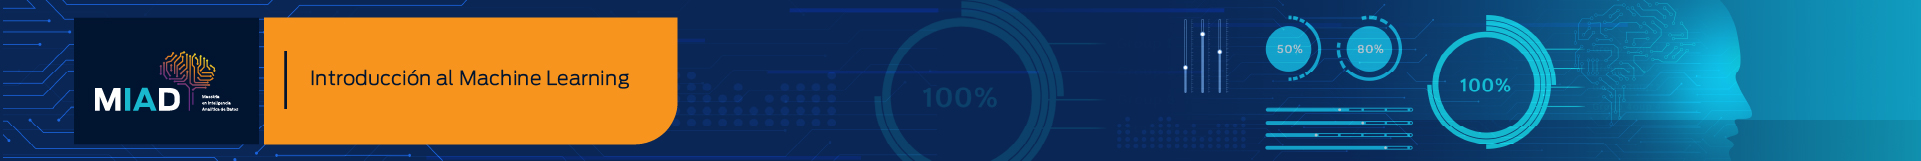

# Proyecto Final Red Nacional de Protección al Consumidor
## Caso: Implementación de modelos problemas de predicción

### Propósito de la actividad

En esta actividad podrán poner en práctica, con un conjunto de datos reales, su habilidad para implementar modelos no lineales aditivos y seleccionar aquel que tenga el mejor desempeño para resolver un problema de regresión. En particular, se deberán implementar modelos MARS y GAM.

Además, como en todo procedimiento de analítica de datos, se evaluará la exploración preliminar de los datos por medio de herramientas como histogramas, correlogramas y estadísticas descriptivas.


### Datos

Para el desarrollo de este proyecto utilizaremos la base de datos del Sistema de Gestión de la Red Nacional de Protección al Consumidor, el cual recibe y gestiona la información correspondiente a los requerimientos que la ciudadanía eleva para que la Super Intendencia de Industria y Comercio en el país de
Colombia ampare sus derechos como consumidor, en aquellos casos que así aplique.  


### 0. Librerias a Importar y Funciones

In [1]:
# Librerias
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.model_selection import train_test_split, KFold, GridSearchCV

from sklearn.tree import plot_tree
from sklearn import metrics
from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor

from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.cross_decomposition import PLSRegression
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import LassoCV
from sklearn.linear_model import ElasticNetCV

from sklearn.preprocessing import OneHotEncoder
from collections import Counter

from sklearn.feature_selection import RFE
from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import RFECV

from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

from scipy.stats import percentileofscore

from datetime import datetime

%matplotlib inline
import warnings

# Para ignorar un warning específico por categoría
#warnings.filterwarnings("ignore", category=DeprecationWarning)
#warnings.filterwarnings("ignore", category=UserWarning)

In [2]:
# Plotting Functions
def plot_hist(variable):
    plt.figure(figsize=(12, 5))
    plt.tight_layout()
    ax = sns.histplot(x=variable)
    value_counts = variable.value_counts()
    # Annotate each bar with its count
    for p in ax.patches:
        count = value_counts.get(p.get_x(),"")
        ax.annotate(f'{p.get_height()}\n{count}', 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='center', xytext=(0, 10), textcoords='offset points')
    # Rotar las leyendas del eje x
    ax.set_xticks(ax.get_xticks()) # added ABC
    ax.set_xticklabels(ax.get_xticklabels(), rotation=30, horizontalalignment='right')
    plt.show()
    return

def plot_hist_woAn(variable):
    plt.figure(figsize=(12, 4))
    plt.tight_layout()
    ax = sns.histplot(x=variable)
    value_counts = variable.value_counts()
    ax.set_xticks(ax.get_xticks()) 
    ax.set_xticklabels(ax.get_xticklabels(), rotation=30, horizontalalignment='right')
    plt.show()
    return

def plot_boxplot(variable):
    plt.figure(figsize=(12, 4))
    plt.tight_layout()
    ax = sns.boxplot(x=variable) 
    plt.show()
    return

def boxplot_var_vs_target(variable,target):
    plt.figure(figsize=(12, 4))
    plt.tight_layout()
    ax = sns.boxplot(x=variable, y=target) 
    ax.set_xticks(ax.get_xticks()) 
    ax.set_xticklabels(ax.get_xticklabels(), rotation=30, horizontalalignment='right')
    plt.show()
    return

def plot_histograms(dataframe):
    # Get the column names of the DataFrame
    columns = dataframe.columns
    # Set up the number of rows and columns for subplots
    num_cols = len(columns)
    num_rows = (num_cols // 3) + (num_cols % 3 > 0)
    # Set up the figure and axes
    fig, axes = plt.subplots(num_rows, 3, figsize=(16, 4 * num_rows))
    fig.tight_layout(pad=3.0)
    plt.subplots_adjust(hspace=0.3)  # Adjust vertical space between subplots
    # Flatten the 2D array of axes to simplify indexing
    axes = axes.flatten()
    # Loop through each column and plot the histogram
    for i, column in enumerate(columns):
        ax = axes[i]
        sns.histplot(dataframe[column], ax=ax, kde = True)
        ax.set_title(f'Histograma de {column}')
    # Remove empty subplots if needed
    for i in range(num_cols, num_rows * 3):
        fig.delaxes(axes[i])     
    plt.show()

def plot_boxplots_vscat(dataframe,target):
    # Get the column names of the DataFrame
    columns = dataframe.select_dtypes(include=['object']).columns
    # Set up the number of rows and columns for subplots
    num_cols = len(columns)
    num_rows = (num_cols // 2) + (num_cols % 2 > 0)  # Change 4 to 3
    # Set up the figure and axes
    fig, axes = plt.subplots(num_rows, 2, figsize=(20, 4 * num_rows))  # Change 4 to 3
    fig.tight_layout(pad=3.0)
    plt.subplots_adjust(hspace=0.3)  # Adjust vertical space between subplots
    # Flatten the 2D array of axes to simplify indexing
    axes = axes.flatten()
    
    # Loop through each column and plot the boxplot with hue
    for i, column in enumerate(columns):
        ax = axes[i]
        sns.boxplot(x=dataframe[column], y=target, ax=ax)
        ax.set_title(f'Boxplot of {column}')
    
    # Remove empty subplots if needed
    for i in range(num_cols, num_rows * 2):
        fig.delaxes(axes[i])     
    plt.show()

In [3]:
import ipywidgets as widgets
from IPython.display import display
# Define a function to handle the selection change
def dropdown_features(df):
    feature_names = list(df.columns)
    # Create a dropdown widget
    ft_dropdown = widgets.Dropdown(
        options=feature_names,
        value=feature_names[0],  # Default value
        description='Select Feature:',
        disabled=False,
    )
    def on_dropdown_change(change):
        global selection
        selection = df[change.new]    
    # Attach the function to the dropdown's change event
    ft_dropdown.observe(on_dropdown_change, names='value')
    # Display the dropdown
    display(ft_dropdown)

In [4]:
def missing_values (df):
    missing_values_df = pd.DataFrame({
        'Missing Count': df.isna().sum(),
        'Missing %': (df.isna().mean() * 100).round(2)
    })
    # Filter the DataFrame to display only features with missing data
    features_with_missing_data = missing_values_df[missing_values_df['Missing Count'] > 0]
    print(features_with_missing_data)
    return

### 1. EXPLORACION DE LOS DATOS (10 puntos)
Realicen un análisis preliminar de los predictores y de la variable de respuesta (correlogramas, histogramas y estadísticas descriptivas).

In [2]:
import os
import pandas as pd

# Convertir la ruta relativa a una ruta absoluta
file_path = os.path.abspath('./ARREGLO_DIRECTO.csv')

# Imprimir la ruta absoluta
print(f"La ruta física del archivo es: {file_path}")

# Leer el archivo como lo estabas haciendo
ad_df = pd.read_csv(file_path, delimiter=';')
print(ad_df.shape)

La ruta física del archivo es: D:\Maestria_Andes_2023\Ciclo_3\Introducción_a_Machine_Learning\8.Semana\ARREGLO_DIRECTO.csv


FileNotFoundError: [Errno 2] No such file or directory: 'D:\\Maestria_Andes_2023\\Ciclo_3\\Introducción_a_Machine_Learning\\8.Semana\\ARREGLO_DIRECTO.csv'

In [5]:
#### Utilicen este espacio para escribir los códigos del procedimiento del punto 1 ####
ad_df= pd.read_csv('./ARREGLO_DIRECTO.csv', delimiter=';')
print(ad_df.shape)

(3991, 34)


#### Diccionario de Datos

- **FECHA_REGISTRO**: 'Fecha y hora en la que se registró el caso o la interacción.',
- **PROYECTO_RNPC**: 'Identificador o nombre del proyecto o programa bajo el cual se registra el caso.',
- **UNIDAD_DEPARTAMENTO**: 'Departamento o unidad administrativa donde se originó o registró el caso.',
- **DESTINO_DEPARTAMENTO**: 'Departamento de destino relacionado con el caso, si aplica.',
- **DESTINO_CIUDAD**: 'Ciudad de destino o implicada en el caso.',
- **ATENCION_TIPO_TRAMITE**: 'Tipo de trámite o servicio solicitado por el ciudadano.',
- **ATENCION_DESTINO**: 'Entidad o destino hacia donde se dirige la atención o el trámite.',
- **ATENCION_TEMA**: 'Tema específico de la atención o consulta realizada.',
- **ATENCION_MOTIVO**: 'Motivo de la atención o consulta.',
- **ATENCION_ESTADO**: 'Estado actual de la atención (ejemplo',
- **PERSONA_RANGO_EDAD**: 'Rango de edad de la persona que realiza la consulta o reporte.',
- **PERSONA_CONDICION_DISCAPACIDAD**: 'Indica si la persona tiene alguna condición de discapacidad.',
- **PERSONA_POBLACION_ESPECIAL**: 'Si la persona pertenece a alguna población especial (podría referirse a grupos vulnerables o minoritarios).',
- **PERSONA_GENERO**: 'Género de la persona.',
- **PERSONA_PROFESION**: 'Profesión u ocupación de la persona.',
- **PERSONA_ACEPTA_HABEAS_DATA**: 'Indica si la persona acepta el tratamiento de sus datos personales (Habeas Data).',
- **TIPO_EMPRESA**: 'Clasificación de la empresa involucrada (Formal, Informal).',
- **EMPRESA_TIPO_DOCUMENTO**: 'Tipo de documento de identificación de la empresa (NIT, CC, etc.).',
- **EMPRESA_NUMERO_DOCUMENTO**: 'Número de documento de identificación de la empresa.',
- **EMPRESA_RAZON_SOCIAL**: 'Razón social de la empresa involucrada.',
- **ESTADO_SERVICIO**: 'Estado actual del servicio o caso (Agendado, Cerrado).',
- **CAUSAL**: 'Causa o razón detrás de la consulta o problema reportado.',
- **TIPO_PRODUCTO**: 'Tipo de producto implicado en el caso (Bien, Servicio).',
- **VALOR_PRODUCTO**: 'Valor monetario del producto o servicio implicado.',
- **FECHA_ADQUISICION**: 'Fecha en la que se adquirió el producto o servicio.',
- **FECHA_ULTIMO_ENCUENTRO**: 'Fecha del último encuentro o interacción relacionada con el caso.',
- **FECHA_FIN_ULTIMO_ENCUENTRO**: 'Fecha de finalización del último encuentro, si aplica.',
- **FECHA_FIN_REAL**: 'Fecha de finalización del último encuentro, si FECHA_FIN_ULTIMO_ENCUENTRO es vacio entonces toma el valor FECHA_ULTIMO_ENCUENTRO.',
- **ENCUENTRO_ACORDADO**: 'Indica si se acordó algún encuentro o seguimiento.',
- **FECHA_CONTRATO**: 'Fecha en la que se firmó un contrato relacionado con el caso, si aplica.',
- **DURACION**: 'Cantidad de días que se demora un regidtro en ser finalizado.',        

In [6]:
ad_df.tail(3)

,PAID,FECHA_REGISTRO,UNIDAD_NOMBRE,PROYECTO_RNPC,UNIDAD_DEPARTAMENTO,DESTINO_DEPARTAMENTO,DESTINO_CIUDAD,ATENCION_TIPO_TRAMITE,ATENCION_DESTINO,ATENCION_TEMA,...,TIPO_PRODUCTO,NOMBRE_PRODUCTO,VALOR_PRODUCTO,FECHA_ADQUISICION,FECHA_ULTIMO_ENCUENTRO,FECHA_FIN_ULTIMO_ENCUENTRO,FECHA_FIN_REAL,ENCUENTRO_ACORDADO,FECHA_CONTRATO,DURACION
3988,1300628,2024-02-08,CR POPAYAN,Casas del Consumidor Regional,CAUCA,CAUCA,POPAYAN,ARREGLO DIRECTO,SIC,Garantías,...,Servicio,servicio de envió de objetos personales,INDETERMINADO,2023-12-18 00:00,2024-02-22,NaN,2024-02-22,NO,NaN,14
3989,703238,2022-04-20,CR PEREIRA,Casas del Consumidor Regional,RISARALDA,RISARALDA,PEREIRA,ARREGLO DIRECTO,SIC,Prestación de servicios que suponen la entrega...,...,Bien,zapatos deportivos color azul NIKE,190000,2022-01-13 00:00,2022-04-28,2022-04-28,2022-04-28,SI,2022-04-28 11:38,8
3990,671016,2022-03-16,CR PEREIRA,Casas del Consumidor Regional,RISARALDA,RISARALDA,PEREIRA,ARREGLO DIRECTO,SIC,Prestación de servicios que suponen la entrega...,...,Bien,Pantalon de dacron marca Kosta Azul,15000,2021-10-15 00:00,2022-03-23,2022-03-23,2022-03-23,SI,2022-03-23 11:00,7


In [7]:
ad_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3991 entries, 0 to 3990
Data columns (total 34 columns):
 #   Column                          Non-Null Count  Dtype 
---  ------                          --------------  ----- 
 0   PAID                            3991 non-null   int64 
 1   FECHA_REGISTRO                  3991 non-null   object
 2   UNIDAD_NOMBRE                   3991 non-null   object
 3   PROYECTO_RNPC                   3991 non-null   object
 4   UNIDAD_DEPARTAMENTO             3991 non-null   object
 5   DESTINO_DEPARTAMENTO            3991 non-null   object
 6   DESTINO_CIUDAD                  3991 non-null   object
 7   ATENCION_TIPO_TRAMITE           3991 non-null   object
 8   ATENCION_DESTINO                3991 non-null   object
 9   ATENCION_TEMA                   3991 non-null   object
 10  ATENCION_MOTIVO                 3991 non-null   object
 11  ATENCION_ESTADO                 3991 non-null   object
 12  PERSONA_RANGO_EDAD              3991 non-null   

In [8]:
duplicate_count = ad_df.duplicated().sum()
duplicate_count

0

### Exploración Univariable

In [11]:
dropdown_features(ad_df)

Dropdown(description='Select Feature:', options=('PAID', 'FECHA_REGISTRO', 'UNIDAD_NOMBRE', 'PROYECTO_RNPC', '…

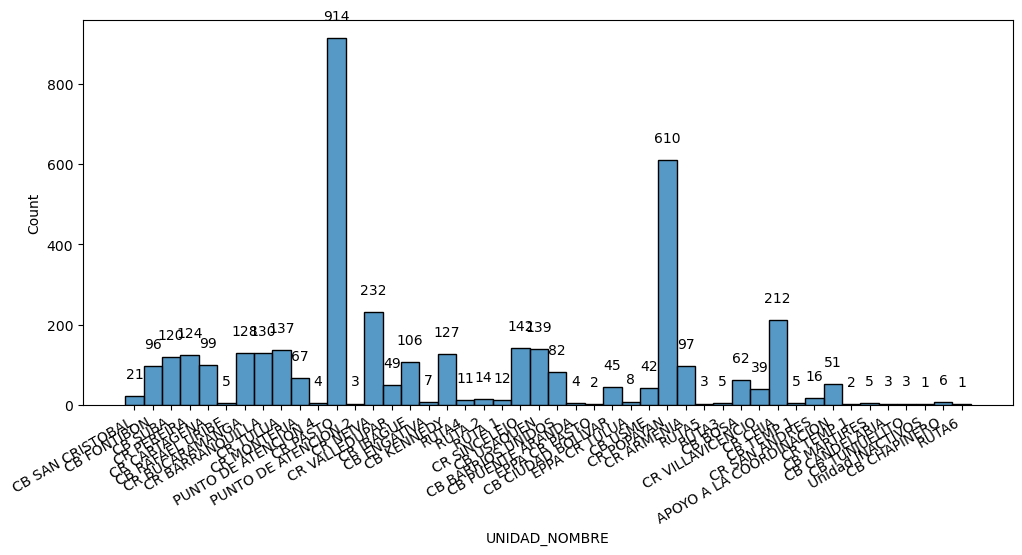

In [13]:
plot_hist(selection)

In [14]:
# To identify specific observations:
#ad_df.loc[ad_df['PERSONA_GENERO'] == 'No indica', :]

In [15]:
selection.describe()

count         3991
unique          46
top       CR PASTO
freq           914
Name: UNIDAD_NOMBRE, dtype: object

In [16]:
selection.value_counts()

UNIDAD_NOMBRE
CR PASTO                   914
CR POPAYAN                 610
CR NEIVA                   232
CR CHIA                    212
CR SINCELEJO               142
CB USAQUEN                 139
CR TULUA                   137
CR BARRANQUILLA            130
CR BUCARAMANGA             128
CB KENNEDY                 127
CR PEREIRA                 124
CB SUBA                    120
CR IBAGUE                  106
CR CARTAGENA                99
CR ARMENIA                  97
CB FONTIBON                 96
CB BARRIOS UNIDOS           82
CR MONTERIA                 67
CB BOSA                     62
APOYO A LA COORDINACION     51
CR VALLEDUPAR               49
CB CIUDAD BOLÍVAR           45
CB USME                     42
CR VILLAVICENCIO            39
CB SAN CRISTOBAL            21
CR SAN ANDRES               16
RUTA 2                      14
RUTA 1                      12
RUTA4                       11
EPPA CR TULUA                8
CB ENGATIVA                  7
CB CHAPINERO             

##### Luego de hacer la exploracion de los datos se hace una limpieza preliminar de los datos:


#### Limpieza Preliminar de los Datos 
**Borrar Observaciones y luego excluir columna:**
- ATENCION_TIPO_TRAMITE = ORIENTACIÓN, ORIENTACIONES - AD, Consulta de caso anterior por parte del ciudadano
- ATENCION_DESTINO = SIC COMUNICACIONES, SUPERFINANCIERA, SUPERSERVICIOS, SUPERTRANSPORTE
- PERSONA_ACEPTA_HABEAS_DATA = NO | Decidido con Miller
- ESTADO_SERVICIO =  AGENDADO REPROGRAMADO Y POSPUESTO - DECIDIDO MILLER Y PAULINA

**Borrar Columnas**
- ATENCION_TIPO_TRAMITE, ATENCION_ESTADO,  ATENCION_DESTINO, EMPRESA TIPO DOCUMENTO, EMPRESA TIPO DOCUMENTO.1, EMPRESA RAZON SOCIAL, PERSONA ACEPTA HABEAS DATA, 'FECHA_ADQUISICION', 'DURACION', 'FECHA_FIN_REAL','FECHA_CONTRATO'

In [17]:
df_prep = ad_df.copy() # df para procesamiento de datos

In [18]:
# Borrar Observaciones fuera de Scope
values_to_drop_ATT = ['ORIENTACIÓN', 'ORIENTACIONES - AD', 'Consulta de caso anterior por parte del ciudadano']
values_to_drop_AD = ['SIC COMUNICACIONES', 'SUPERFINANCIERA', 'SUPERSERVICIOS', 'SUPERTRANSPORTE']
values_to_drop_HBD = ['NO']
values_to_drop_EST =['AGENDADO', 'REPROGRAMADO', 'POSPUESTO']

In [19]:
# Drop rows with specific values in-place
df_prep=df_prep[~df_prep['ATENCION_TIPO_TRAMITE'].isin(values_to_drop_ATT)]
df_prep=df_prep[~df_prep['ATENCION_DESTINO'].isin(values_to_drop_AD)]
df_prep=df_prep[~df_prep['PERSONA_ACEPTA_HABEAS_DATA'].isin(values_to_drop_HBD)]
df_prep=df_prep[~df_prep['ESTADO_SERVICIO'].isin(values_to_drop_EST)]

In [20]:
# Columnas a borrar
columns_to_drop = [
    'PAID',       
    'ATENCION_TIPO_TRAMITE', 'ATENCION_DESTINO', 
    'ATENCION_ESTADO',
    'PERSONA_ACEPTA_HABEAS_DATA',
    'EMPRESA_TIPO_DOCUMENTO', 'EMPRESA_TIPO_DOCUMENTO.1',
    'EMPRESA_RAZON_SOCIAL',
    'FECHA_ADQUISICION', 'DURACION',
    'FECHA_FIN_REAL', 'FECHA_CONTRATO'
    ]

In [21]:
# Borrar Columnas
df_prep.drop(columns=columns_to_drop, inplace=True)

In [22]:
len(df_prep)/len(ad_df)

0.9456276622400401

In [23]:
prep1_size = len(df_prep)

### Construccion Variable de Respuesta : DURACION_PROCESO
- FECHAS A DATE_TIME
- Construccion FECHA_ULTIMA = MAX['FECHA_ULTIMO_ENCUENTRO','FECHA_FIN_ULTIMO_ENCUENTRO']
- DURACION_PROCESO = FECHA_ULTIMA - FECHA REGISTRO

In [24]:
# Conversion Fechas a Datetime
fecha_columns = [col for col in df_prep.columns if col.startswith('FECHA')]
# Convert each column to datetime
for col in fecha_columns:
    df_prep[col] = pd.to_datetime(df_prep[col])

In [25]:
df_prep['FECHA_ULTIMA'] = df_prep[['FECHA_ULTIMO_ENCUENTRO', 'FECHA_FIN_ULTIMO_ENCUENTRO']].max(axis=1)

In [26]:
df_prep['DURACION_PROCESO'] = (df_prep['FECHA_ULTIMA'] - df_prep['FECHA_REGISTRO']).dt.days

In [27]:
df_prep['DURACION_PROCESO'].describe()

count    3774.000000
mean       15.746158
std        36.417721
min         0.000000
25%         6.000000
50%         9.000000
75%        15.000000
max      1022.000000
Name: DURACION_PROCESO, dtype: float64

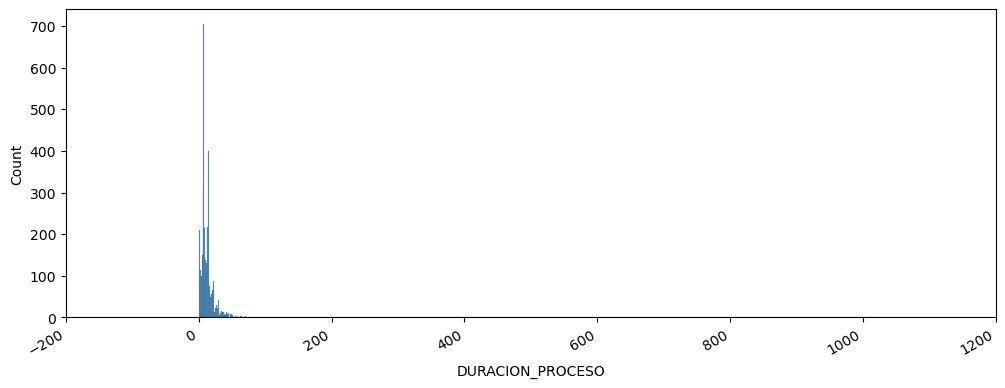

In [28]:
plot_hist_woAn(df_prep['DURACION_PROCESO']) # Distribucion variable de respuesta

#### Acotando los valores de DURACION_PROCESO para Analisis. 

In [29]:
bin_edges_D = [-1, 7, 14, 21, 28, 45, 90, 1080]
df_prep['DURACION_DSC'] = pd.cut(df_prep['DURACION_PROCESO'], bins=bin_edges_D)

In [30]:
df_prep['DURACION_DSC'].value_counts()

DURACION_DSC
(-1, 7]       1373
(7, 14]       1362
(14, 21]       533
(21, 28]       201
(28, 45]       182
(45, 90]        76
(90, 1080]      47
Name: count, dtype: int64

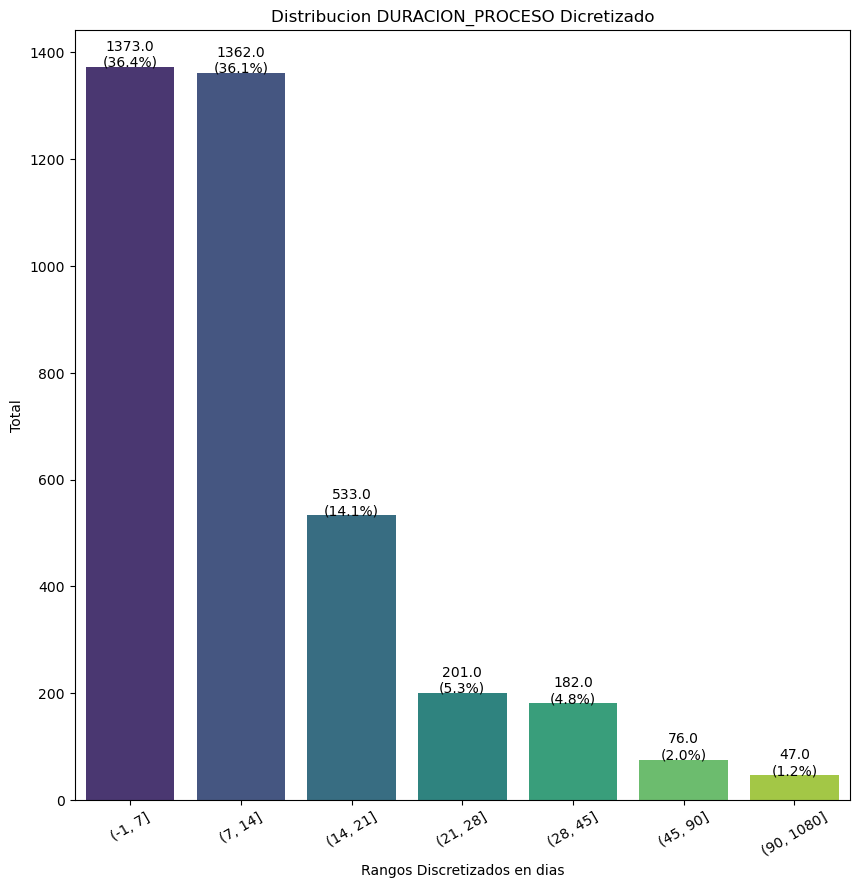

In [31]:
plt.figure(figsize=(10,10))
ax = sns.countplot(x='DURACION_DSC', data=df_prep, palette='viridis')
for p in ax.patches:
    count = p.get_height()
    percentage = count / len(df_prep) * 100
    ax.text(p.get_x() + p.get_width() / 2, p.get_height() + 0.1, f'{count}\n({percentage:.1f}%)', ha='center')

plt.title('Distribucion DURACION_PROCESO Dicretizado')
plt.xlabel('Rangos Discretizados en dias')
plt.ylabel('Total')
plt.xticks(rotation=30)
plt.show()

In [32]:
percentil_90= df_prep['DURACION_PROCESO'].quantile(0.90)
percentil_90

26.0

In [33]:
percentil_95= df_prep['DURACION_PROCESO'].quantile(0.95)
percentil_95

37.0

In [34]:
# Numero Observaciones DURACION_PROCESO > 
df_prep.loc[(df_prep['DURACION_PROCESO'] > 60), ['ESTADO_SERVICIO', 'DESTINO_CIUDAD', 'NOMBRE_PRODUCTO','VALOR_PRODUCTO','DURACION_PROCESO']]

,ESTADO_SERVICIO,DESTINO_CIUDAD,NOMBRE_PRODUCTO,VALOR_PRODUCTO,DURACION_PROCESO
2,CERRADO,FONTIBON,celular,100000,120
5,CERRADO,PEREIRA,alquiler de vestido negro para celebracion de ...,300000,146
55,CERRADO,IBAGUE,Persianas,112000,391
116,ACORDADO,PASTO,compraventa de bien inmueble,95382926,71
164,ACORDADO,CARTAGENA,congelador,6000000,74
...,...,...,...,...,...
3596,CERRADO,ENGATIVA,Nevera Marca LG 410 Litros,1150000,382
3601,CERRADO-IAP,BARRANQUILLA,Pantalla para celular Kalley,168000,485
3792,CERRADO-IAP,VILLAVICENCIO,CALZADO,172000,75
3847,CERRADO,CARTAGENA,Automóvil marca Chevrolet modelo JOY BLACK AC ...,40990000,90


### Comportamiento Variable Respuesta Acotada vs. Predictoras

In [35]:
df_bivar = df_prep.copy()

In [36]:
df_bivar['DURACION_ACO'] = df_bivar['DURACION_PROCESO'] #DURACION ACOTADA PARA ANALISIS

In [37]:
quantile_value = round(percentileofscore(df_bivar['DURACION_PROCESO'], 30, kind='rank'),2)
quantile_value

92.85

In [38]:
# Acotando la duracion a 30 dias.
df_bivar['DURACION_ACO'] = np.where(df_bivar['DURACION_ACO'] > 30, 30, df_bivar['DURACION_ACO'])

In [39]:
#df_bivar['DURACION_ACO'].describe()

In [40]:
#df_bivar.columns

In [41]:
df_bivar.drop(columns=['FECHA_REGISTRO','NOMBRE_PRODUCTO',
       'VALOR_PRODUCTO', 'FECHA_ULTIMO_ENCUENTRO', 'ESTADO_SERVICIO',
       'FECHA_FIN_ULTIMO_ENCUENTRO', 'ENCUENTRO_ACORDADO', 'FECHA_ULTIMA',
       'DURACION_PROCESO', 'DURACION_DSC'], inplace=True)

In [42]:
dropdown_features(df_bivar)

Dropdown(description='Select Feature:', options=('UNIDAD_NOMBRE', 'PROYECTO_RNPC', 'UNIDAD_DEPARTAMENTO', 'DES…

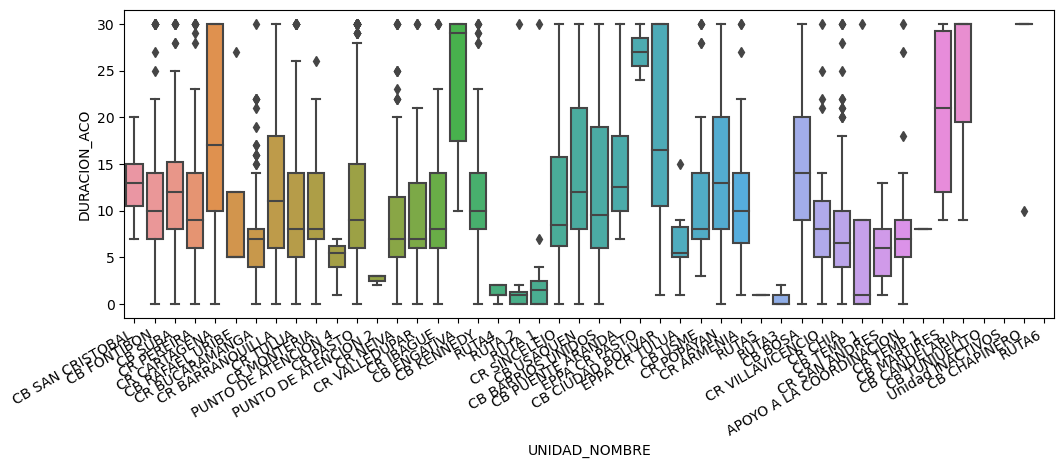

In [43]:
boxplot_var_vs_target(selection,df_bivar['DURACION_ACO'])

#### VARIABLES QUE SE QUEDAN (SO FAR):
UNIDAD_NOMBRE
PROYECTO_RNPC
UNIDAD_DEPARTAMENTO
DESTINO_DEPARTAMENTO
DESTINO_CIUDAD
ATENCION_TEMA (Incluye Arreglo Directo)
ATENCION_MOTIVO (Incluye Arreglo Directo)
PERSONA_RANGO_EDAD
PERSONA_CONDICION_DISCAPACIDAD
PERSONA_POBLACION_ESPECIAL
PERSONA_GENERO?
PERSONA_PROFESION (En realidad es Educacion)
TIPO_EMPRESA
CAUSAL
TIPO_PRODUCTO

### 2. PREPARACION DE LOS DATOS  (10 puntos)

#### NOTAS PREPROCESAMIENTO

1. Conversion de datos 
- Convertir VALOR_DEL_PRODUCTO a numerico, para entenderlo
- luego discretizarlo 

2. Identificacion Datos Faltantes

3. Outliers

4. Seleccion de variables

PENDIENTES CORREGIR:

- Diccionario de Datos

#### Conversion de Variables

In [44]:
null_values_location = df_prep[df_prep['VALOR_PRODUCTO'].isnull()]
null_values_location

,FECHA_REGISTRO,UNIDAD_NOMBRE,PROYECTO_RNPC,UNIDAD_DEPARTAMENTO,DESTINO_DEPARTAMENTO,DESTINO_CIUDAD,ATENCION_TEMA,ATENCION_MOTIVO,PERSONA_RANGO_EDAD,PERSONA_CONDICION_DISCAPACIDAD,...,CAUSAL,TIPO_PRODUCTO,NOMBRE_PRODUCTO,VALOR_PRODUCTO,FECHA_ULTIMO_ENCUENTRO,FECHA_FIN_ULTIMO_ENCUENTRO,ENCUENTRO_ACORDADO,FECHA_ULTIMA,DURACION_PROCESO,DURACION_DSC
3537,2023-04-13,CR POPAYAN,Casas del Consumidor Regional,CAUCA,CAUCA,POPAYAN,Garantías,Incumplimiento de los términos de garantía,26-40 años,Ninguna,...,Información o publicidad engañosa,Servicio,servicio de odontología,NaN,2023-04-25,2023-05-11,NO,2023-05-11,28,"(21, 28]"


In [45]:
# Descartar valor nulo en "VALOR_PRODUCTO"
df_prep.dropna(subset=['VALOR_PRODUCTO'], inplace=True)

In [46]:
# Conversion 'VALOR_PRODUCTO' a numerico para tratamiento de outliers
df_prep['VALOR_PRODUCTO_NUM'] = pd.to_numeric(df_prep['VALOR_PRODUCTO'], errors='coerce')/1000000

In [47]:
df_prep['VALOR_PRODUCTO_NUM'].describe()

count    3520.000000
mean       13.448793
std        55.377262
min         0.000000
25%         0.449975
50%         1.590000
75%         5.000000
max      1200.000000
Name: VALOR_PRODUCTO_NUM, dtype: float64

#### Identificación Datos Faltantes

In [48]:
missing_values(df_prep)

                            Missing Count  Missing %
FECHA_FIN_ULTIMO_ENCUENTRO             32       0.85
VALOR_PRODUCTO_NUM                    253       6.71


#### Se generan los datos faltantes en VALOR_PRODUCTO: de INDETERMINADO a NaN

#### Tratamiento Outliers

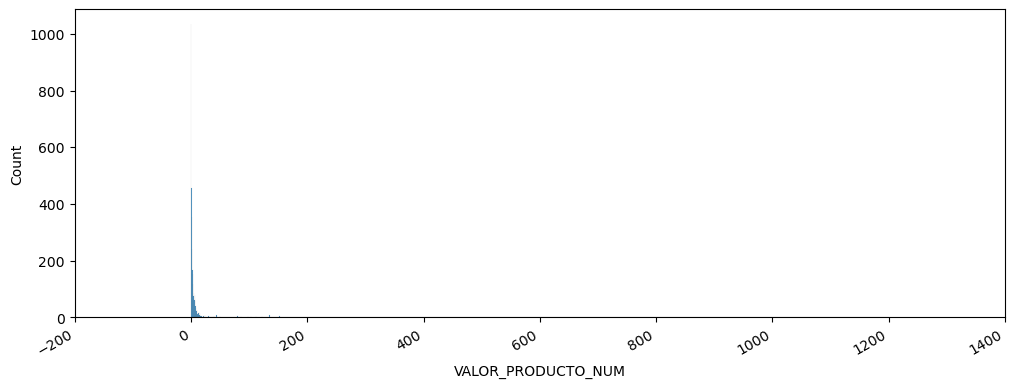

In [49]:
plot_hist_woAn(df_prep['VALOR_PRODUCTO_NUM'])

In [50]:
# Valor == 0?
df_prep[df_prep['VALOR_PRODUCTO_NUM'] <= 0] 

,FECHA_REGISTRO,UNIDAD_NOMBRE,PROYECTO_RNPC,UNIDAD_DEPARTAMENTO,DESTINO_DEPARTAMENTO,DESTINO_CIUDAD,ATENCION_TEMA,ATENCION_MOTIVO,PERSONA_RANGO_EDAD,PERSONA_CONDICION_DISCAPACIDAD,...,TIPO_PRODUCTO,NOMBRE_PRODUCTO,VALOR_PRODUCTO,FECHA_ULTIMO_ENCUENTRO,FECHA_FIN_ULTIMO_ENCUENTRO,ENCUENTRO_ACORDADO,FECHA_ULTIMA,DURACION_PROCESO,DURACION_DSC,VALOR_PRODUCTO_NUM
68,2022-08-12,CR TULUA,Casas del Consumidor Regional,VALLE DEL CAUCA,VALLE DEL CAUCA,TULUA,Protección Contractual,Incumplimiento Contractual,41-59 años,Ninguna,...,Servicio,administrativo,0,2022-08-12,2022-08-12,SI,2022-08-12,0,"(-1, 7]",0.0


#### Discretizando los valores de VALOR_PRODUCTO para Manejo de Outliers, y Categorizarlo. 

In [51]:
#bin_edges_VP = [0, 0.5, 1.5, 5, 100, 250, 500, 1500, 15000]
#df_prep['VALOR_PRODUCTO_DSC'] = pd.cut(df_prep['VALOR_PRODUCTO_NUM'], bins=bin_edges_VP, include_lowest = True)

In [52]:
df_prep['VALOR_PRODUCTO_DSC'] = pd.qcut(df_prep['VALOR_PRODUCTO_NUM'], q=10) # solo para visualizacion

In [53]:
val_prod_bins10qtl = pd.qcut(df_prep['VALOR_PRODUCTO_NUM'], q=10)
# Assign the resulting intervals as labels to a new column
df_prep['VALOR_PRODUCTO_QCUT10'] = val_prod_bins10qtl.astype(str)

In [54]:
#df_prep['VALOR_PRODUCTO_QCUT10'] = pd.qcut(df_prep['VALOR_PRODUCTO_NUM'], q=10, labels = False)

In [55]:
df_prep['VALOR_PRODUCTO_DSC'].value_counts()

VALOR_PRODUCTO_DSC
(-0.001, 0.15]      361
(0.33, 0.6]         352
(1.0, 1.59]         352
(1.59, 2.5]         352
(2.5, 3.9]          352
(3.9, 6.5]          352
(17.803, 1200.0]    352
(6.5, 17.803]       351
(0.15, 0.33]        349
(0.6, 1.0]          347
Name: count, dtype: int64

In [56]:
df_prep['VALOR_PRODUCTO_QCUT10'].value_counts() # luego reemplazaremos nan por 'INDETERMINADO'

VALOR_PRODUCTO_QCUT10
(-0.001, 0.15]      361
(17.803, 1200.0]    352
(2.5, 3.9]          352
(1.0, 1.59]         352
(0.33, 0.6]         352
(3.9, 6.5]          352
(1.59, 2.5]         352
(6.5, 17.803]       351
(0.15, 0.33]        349
(0.6, 1.0]          347
nan                 253
Name: count, dtype: int64

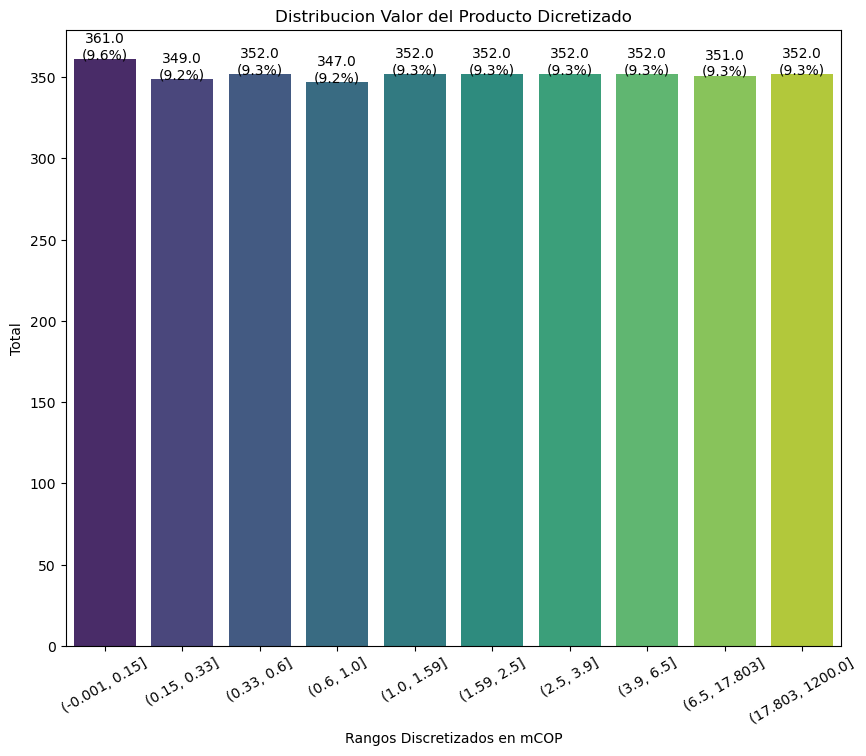

In [57]:
plt.figure(figsize=(10,8))
ax = sns.countplot(x='VALOR_PRODUCTO_DSC', data = df_prep,  palette='viridis')
for p in ax.patches:
    count = p.get_height()
    percentage = count / len(df_prep) * 100
    ax.text(p.get_x() + p.get_width() / 2, p.get_height() + 0.1, f'{count}\n({percentage:.1f}%)', ha='center')
plt.title('Distribucion Valor del Producto Dicretizado')
plt.xlabel('Rangos Discretizados en mCOP')
plt.ylabel('Total')
plt.xticks(rotation=30)
plt.show()

#### Comentarios Outliers

- Hay errores en los precios de las motos.
- Los apartamentos en Cartagena parecen datos duplicados
- Descartar los valores > 500?

In [58]:
# Maximo VALOR_PRODUCTO
df_prep.loc[(df_prep['VALOR_PRODUCTO_NUM'] > 500), ['FECHA_REGISTRO','ESTADO_SERVICIO','UNIDAD_NOMBRE', 'DESTINO_CIUDAD', 'NOMBRE_PRODUCTO','VALOR_PRODUCTO', 'DURACION_PROCESO']]

,FECHA_REGISTRO,ESTADO_SERVICIO,UNIDAD_NOMBRE,DESTINO_CIUDAD,NOMBRE_PRODUCTO,VALOR_PRODUCTO,DURACION_PROCESO
501,2021-07-21,CERRADO,CR MONTERIA,MONTERIA,BIEN INMUEBLE - CASA,1200000000,14
765,2022-10-03,ACORDADO,CR NEIVA,NEIVA,curso de ingles,599000000,15
946,2022-03-02,CERRADO,CR CARTAGENA,CARTAGENA,"Motocicleta DOMINAR modelo 2022, referencia 25...",1148999885,15
1040,2022-07-27,CERRADO-NA,CB CIUDAD BOLÍVAR,CIUDAD BOLIVAR,motocicleta hero dash 125 fi motor jf17eklgc00050,613999990,20
1178,2021-04-13,CERRADO,CR CARTAGENA,CARTAGENA,3 apartamentos,829821920,41
1179,2021-04-13,CERRADO,CR CARTAGENA,CARTAGENA,3 apartamentos,829821920,41
1181,2021-04-13,CERRADO,CR CARTAGENA,CARTAGENA,3 apartamentos,829821920,41
2074,2021-06-22,CERRADO,CB USAQUEN,USAQUEN,inmueble,749000000,14
2729,2022-04-25,CERRADO,CR CHIA,CHIA,Bien inmueble,609000000,7


In [59]:
# Dropping Observaciones con errores en los precios
indexes_to_drop = [765, 946, 1040]
# Drop the observations with specified indexes
df_prep = df_prep.drop(indexes_to_drop)

In [60]:
#df_prep['VALOR_PRODUCTO_QCUT10'].fillna('INDETERMINADO', inplace=True)

In [61]:
df_prep['VALOR_PRODUCTO_QCUT10'] = np.where(df_prep['VALOR_PRODUCTO_QCUT10'] == 'nan', 'INDETERMINADO', df_prep['VALOR_PRODUCTO_QCUT10'])

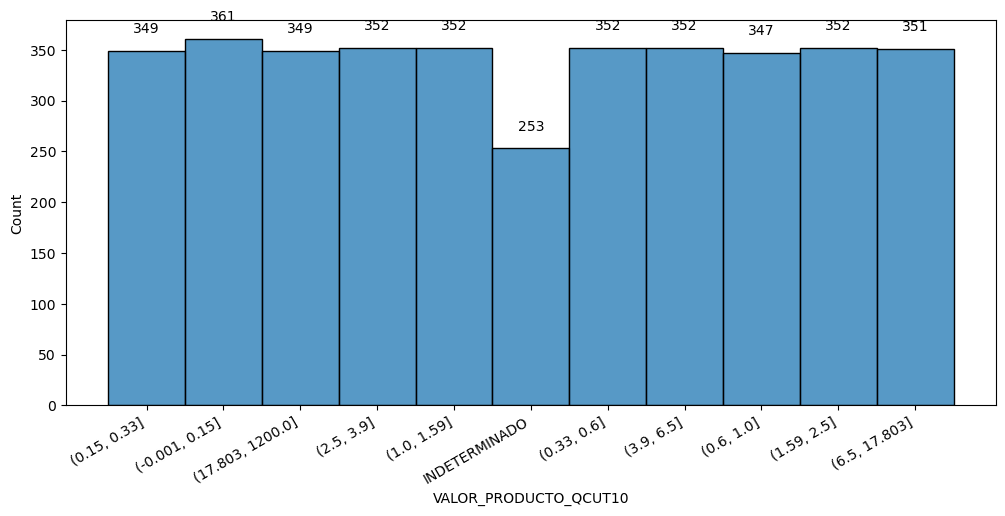

In [62]:
plot_hist(df_prep['VALOR_PRODUCTO_QCUT10'])

### Tratamiento outliers en Y : Maxima duracion 30 dias equivalente al percentil 92.85% 

In [63]:
# Acotando la duracion a 60 dias.
df_prep['DURACION_ACO'] = df_prep['DURACION_PROCESO'] 
df_prep['DURACION_ACO'] = np.where(df_prep['DURACION_ACO'] > 30, 30, df_prep['DURACION_ACO'])
df_prep['DURACION_ACO'].describe()

count    3770.000000
mean       11.790186
std         7.962719
min         0.000000
25%         6.000000
50%         9.000000
75%        15.000000
max        30.000000
Name: DURACION_ACO, dtype: float64

In [64]:
df_prep.to_csv('df_prep.csv', index=False)

#### Preseleccion de Variables

In [65]:
#data_bckup= pd.read_csv('./df_prep.csv')

In [66]:
#data_bckup.head()

In [67]:
data = df_prep.copy()

In [68]:
data.head()

,FECHA_REGISTRO,UNIDAD_NOMBRE,PROYECTO_RNPC,UNIDAD_DEPARTAMENTO,DESTINO_DEPARTAMENTO,DESTINO_CIUDAD,ATENCION_TEMA,ATENCION_MOTIVO,PERSONA_RANGO_EDAD,PERSONA_CONDICION_DISCAPACIDAD,...,FECHA_ULTIMO_ENCUENTRO,FECHA_FIN_ULTIMO_ENCUENTRO,ENCUENTRO_ACORDADO,FECHA_ULTIMA,DURACION_PROCESO,DURACION_DSC,VALOR_PRODUCTO_NUM,VALOR_PRODUCTO_DSC,VALOR_PRODUCTO_QCUT10,DURACION_ACO
0,2022-01-21,CB SAN CRISTOBAL,Casas del Consumidor Bogota,BOGOTA,BOGOTA,SAN CRISTOBAL,Garantías,Incumplimiento de los términos de garantía,60-80 años,Ninguna,...,2022-01-31,2022-02-01,SI,2022-02-01,11,"(7, 14]",0.22,"(0.15, 0.33]","(0.15, 0.33]",11
1,2021-03-05,CB FONTIBON,Casas del Consumidor Bogota,BOGOTA,BOGOTA,FONTIBON,Prestación de servicios que suponen la entrega...,Abandono de bienes,41-59 años,Ninguna,...,2021-03-10,2021-03-10,SI,2021-03-10,5,"(-1, 7]",0.18,"(0.15, 0.33]","(0.15, 0.33]",5
2,2020-10-28,CB FONTIBON,Casas del Consumidor Bogota,BOGOTA,BOGOTA,FONTIBON,Garantías,Incumplimiento de los términos de garantía,26-40 años,Ninguna,...,2020-10-28,2021-02-25,SI,2021-02-25,120,"(90, 1080]",0.10,"(-0.001, 0.15]","(-0.001, 0.15]",30
3,2020-11-11,CB SUBA,Casas del Consumidor Bogota,BOGOTA,BOGOTA,SUBA,Información o publicidad engañosa,Incumplimiento en la entrega de la información...,41-59 años,Ninguna,...,2020-11-26,2020-11-26,SI,2020-11-26,15,"(14, 21]",22.50,"(17.803, 1200.0]","(17.803, 1200.0]",15
4,2021-07-14,CB SUBA,Casas del Consumidor Bogota,BOGOTA,BOGOTA,SUBA,Garantías,Incumplimiento de los términos de garantía,60-80 años,Ninguna,...,2021-08-05,2021-08-05,SI,2021-08-05,22,"(21, 28]",2.60,"(2.5, 3.9]","(2.5, 3.9]",22


In [69]:
data.columns

Index(['FECHA_REGISTRO', 'UNIDAD_NOMBRE', 'PROYECTO_RNPC',
       'UNIDAD_DEPARTAMENTO', 'DESTINO_DEPARTAMENTO', 'DESTINO_CIUDAD',
       'ATENCION_TEMA', 'ATENCION_MOTIVO', 'PERSONA_RANGO_EDAD',
       'PERSONA_CONDICION_DISCAPACIDAD', 'PERSONA_POBLACION_ESPECIAL',
       'PERSONA_GENERO', 'PERSONA_PROFESION', 'TIPO_EMPRESA',
       'ESTADO_SERVICIO', 'CAUSAL', 'TIPO_PRODUCTO', 'NOMBRE_PRODUCTO',
       'VALOR_PRODUCTO', 'FECHA_ULTIMO_ENCUENTRO',
       'FECHA_FIN_ULTIMO_ENCUENTRO', 'ENCUENTRO_ACORDADO', 'FECHA_ULTIMA',
       'DURACION_PROCESO', 'DURACION_DSC', 'VALOR_PRODUCTO_NUM',
       'VALOR_PRODUCTO_DSC', 'VALOR_PRODUCTO_QCUT10', 'DURACION_ACO'],
      dtype='object')

In [70]:
columns_to_drop1 = ['FECHA_REGISTRO', 'NOMBRE_PRODUCTO', 'ESTADO_SERVICIO',
                    'VALOR_PRODUCTO', 'FECHA_ULTIMO_ENCUENTRO', 
                    'FECHA_FIN_ULTIMO_ENCUENTRO', 'FECHA_ULTIMA',
                    'ENCUENTRO_ACORDADO', 'DURACION_DSC', 'VALOR_PRODUCTO_NUM',
                    'VALOR_PRODUCTO_DSC', 'DURACION_PROCESO']
data.drop(columns=columns_to_drop1, inplace=True)

In [71]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3770 entries, 0 to 3990
Data columns (total 17 columns):
 #   Column                          Non-Null Count  Dtype 
---  ------                          --------------  ----- 
 0   UNIDAD_NOMBRE                   3770 non-null   object
 1   PROYECTO_RNPC                   3770 non-null   object
 2   UNIDAD_DEPARTAMENTO             3770 non-null   object
 3   DESTINO_DEPARTAMENTO            3770 non-null   object
 4   DESTINO_CIUDAD                  3770 non-null   object
 5   ATENCION_TEMA                   3770 non-null   object
 6   ATENCION_MOTIVO                 3770 non-null   object
 7   PERSONA_RANGO_EDAD              3770 non-null   object
 8   PERSONA_CONDICION_DISCAPACIDAD  3770 non-null   object
 9   PERSONA_POBLACION_ESPECIAL      3770 non-null   object
 10  PERSONA_GENERO                  3770 non-null   object
 11  PERSONA_PROFESION               3770 non-null   object
 12  TIPO_EMPRESA                    3770 non-null   objec

In [72]:
dropdown_features(data)

Dropdown(description='Select Feature:', options=('UNIDAD_NOMBRE', 'PROYECTO_RNPC', 'UNIDAD_DEPARTAMENTO', 'DES…

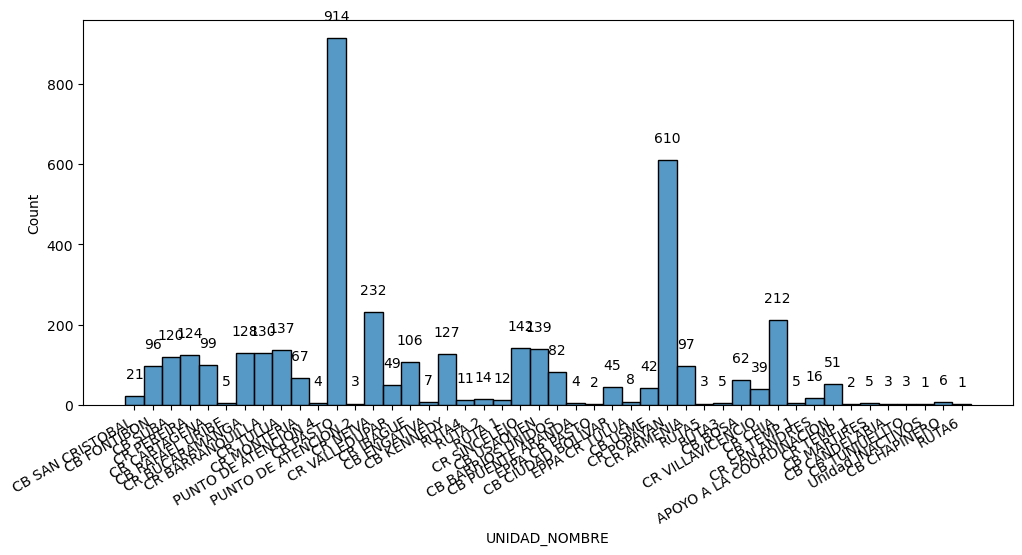

In [73]:
plot_hist(selection)

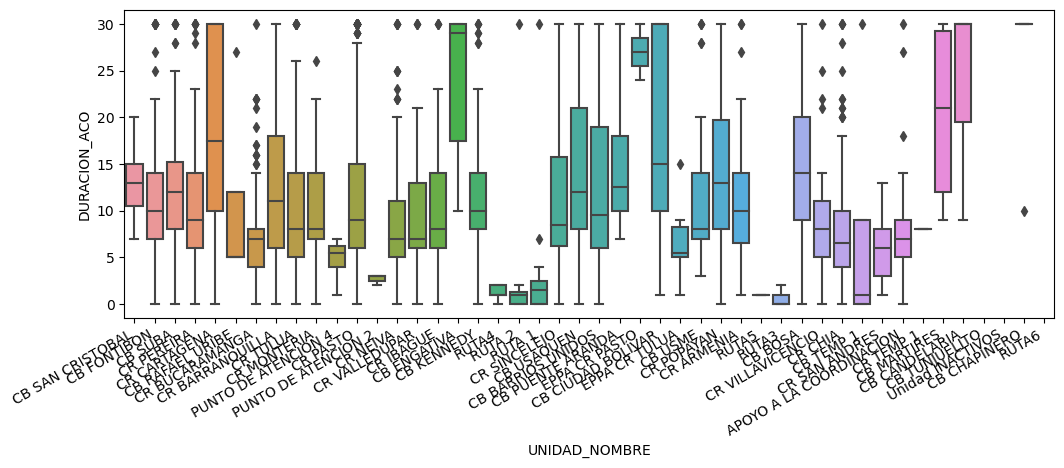

In [74]:
boxplot_var_vs_target(selection,data['DURACION_ACO'])

In [75]:
selection.describe()

count         3991
unique          46
top       CR PASTO
freq           914
Name: UNIDAD_NOMBRE, dtype: object

In [76]:
selection.value_counts()

UNIDAD_NOMBRE
CR PASTO                   914
CR POPAYAN                 610
CR NEIVA                   232
CR CHIA                    212
CR SINCELEJO               142
CB USAQUEN                 139
CR TULUA                   137
CR BARRANQUILLA            130
CR BUCARAMANGA             128
CB KENNEDY                 127
CR PEREIRA                 124
CB SUBA                    120
CR IBAGUE                  106
CR CARTAGENA                99
CR ARMENIA                  97
CB FONTIBON                 96
CB BARRIOS UNIDOS           82
CR MONTERIA                 67
CB BOSA                     62
APOYO A LA COORDINACION     51
CR VALLEDUPAR               49
CB CIUDAD BOLÍVAR           45
CB USME                     42
CR VILLAVICENCIO            39
CB SAN CRISTOBAL            21
CR SAN ANDRES               16
RUTA 2                      14
RUTA 1                      12
RUTA4                       11
EPPA CR TULUA                8
CB ENGATIVA                  7
CB CHAPINERO             

### Separacion XTotal, yTotal

In [77]:
var_preseleccionadas = ['PROYECTO_RNPC','DESTINO_DEPARTAMENTO', 'PERSONA_RANGO_EDAD',
                        'PERSONA_CONDICION_DISCAPACIDAD', 'PERSONA_POBLACION_ESPECIAL',
                        'PERSONA_GENERO', 'PERSONA_PROFESION', 'TIPO_EMPRESA', 'CAUSAL',
                        'TIPO_PRODUCTO', 'VALOR_PRODUCTO_QCUT10']

In [78]:
XTotal = data[var_preseleccionadas]
yTotal = data.loc[:,data.columns=='DURACION_ACO']

In [79]:
XTotal.head()

,PROYECTO_RNPC,DESTINO_DEPARTAMENTO,PERSONA_RANGO_EDAD,PERSONA_CONDICION_DISCAPACIDAD,PERSONA_POBLACION_ESPECIAL,PERSONA_GENERO,PERSONA_PROFESION,TIPO_EMPRESA,CAUSAL,TIPO_PRODUCTO,VALOR_PRODUCTO_QCUT10
0,Casas del Consumidor Bogota,BOGOTA,60-80 años,Ninguna,Ninguna,Hombre,Técnico,INFORMAL,Servicios que suponen la entrega de un bien a ...,Bien,"(0.15, 0.33]"
1,Casas del Consumidor Bogota,BOGOTA,41-59 años,Ninguna,Ninguna,Mujer,Bachiller,INFORMAL,Incumplimiento contractual,Bien,"(0.15, 0.33]"
2,Casas del Consumidor Bogota,BOGOTA,26-40 años,Ninguna,Ninguna,Mujer,Ninguno,INFORMAL,Información o publicidad engañosa,Bien,"(-0.001, 0.15]"
3,Casas del Consumidor Bogota,BOGOTA,41-59 años,Ninguna,No indica,Mujer,Bachiller,FORMAL,Información o publicidad engañosa,Bien,"(17.803, 1200.0]"
4,Casas del Consumidor Bogota,BOGOTA,60-80 años,Ninguna,Ninguna,Hombre,Profesional,INFORMAL,Incumplimiento de la garantía,Servicio,"(2.5, 3.9]"


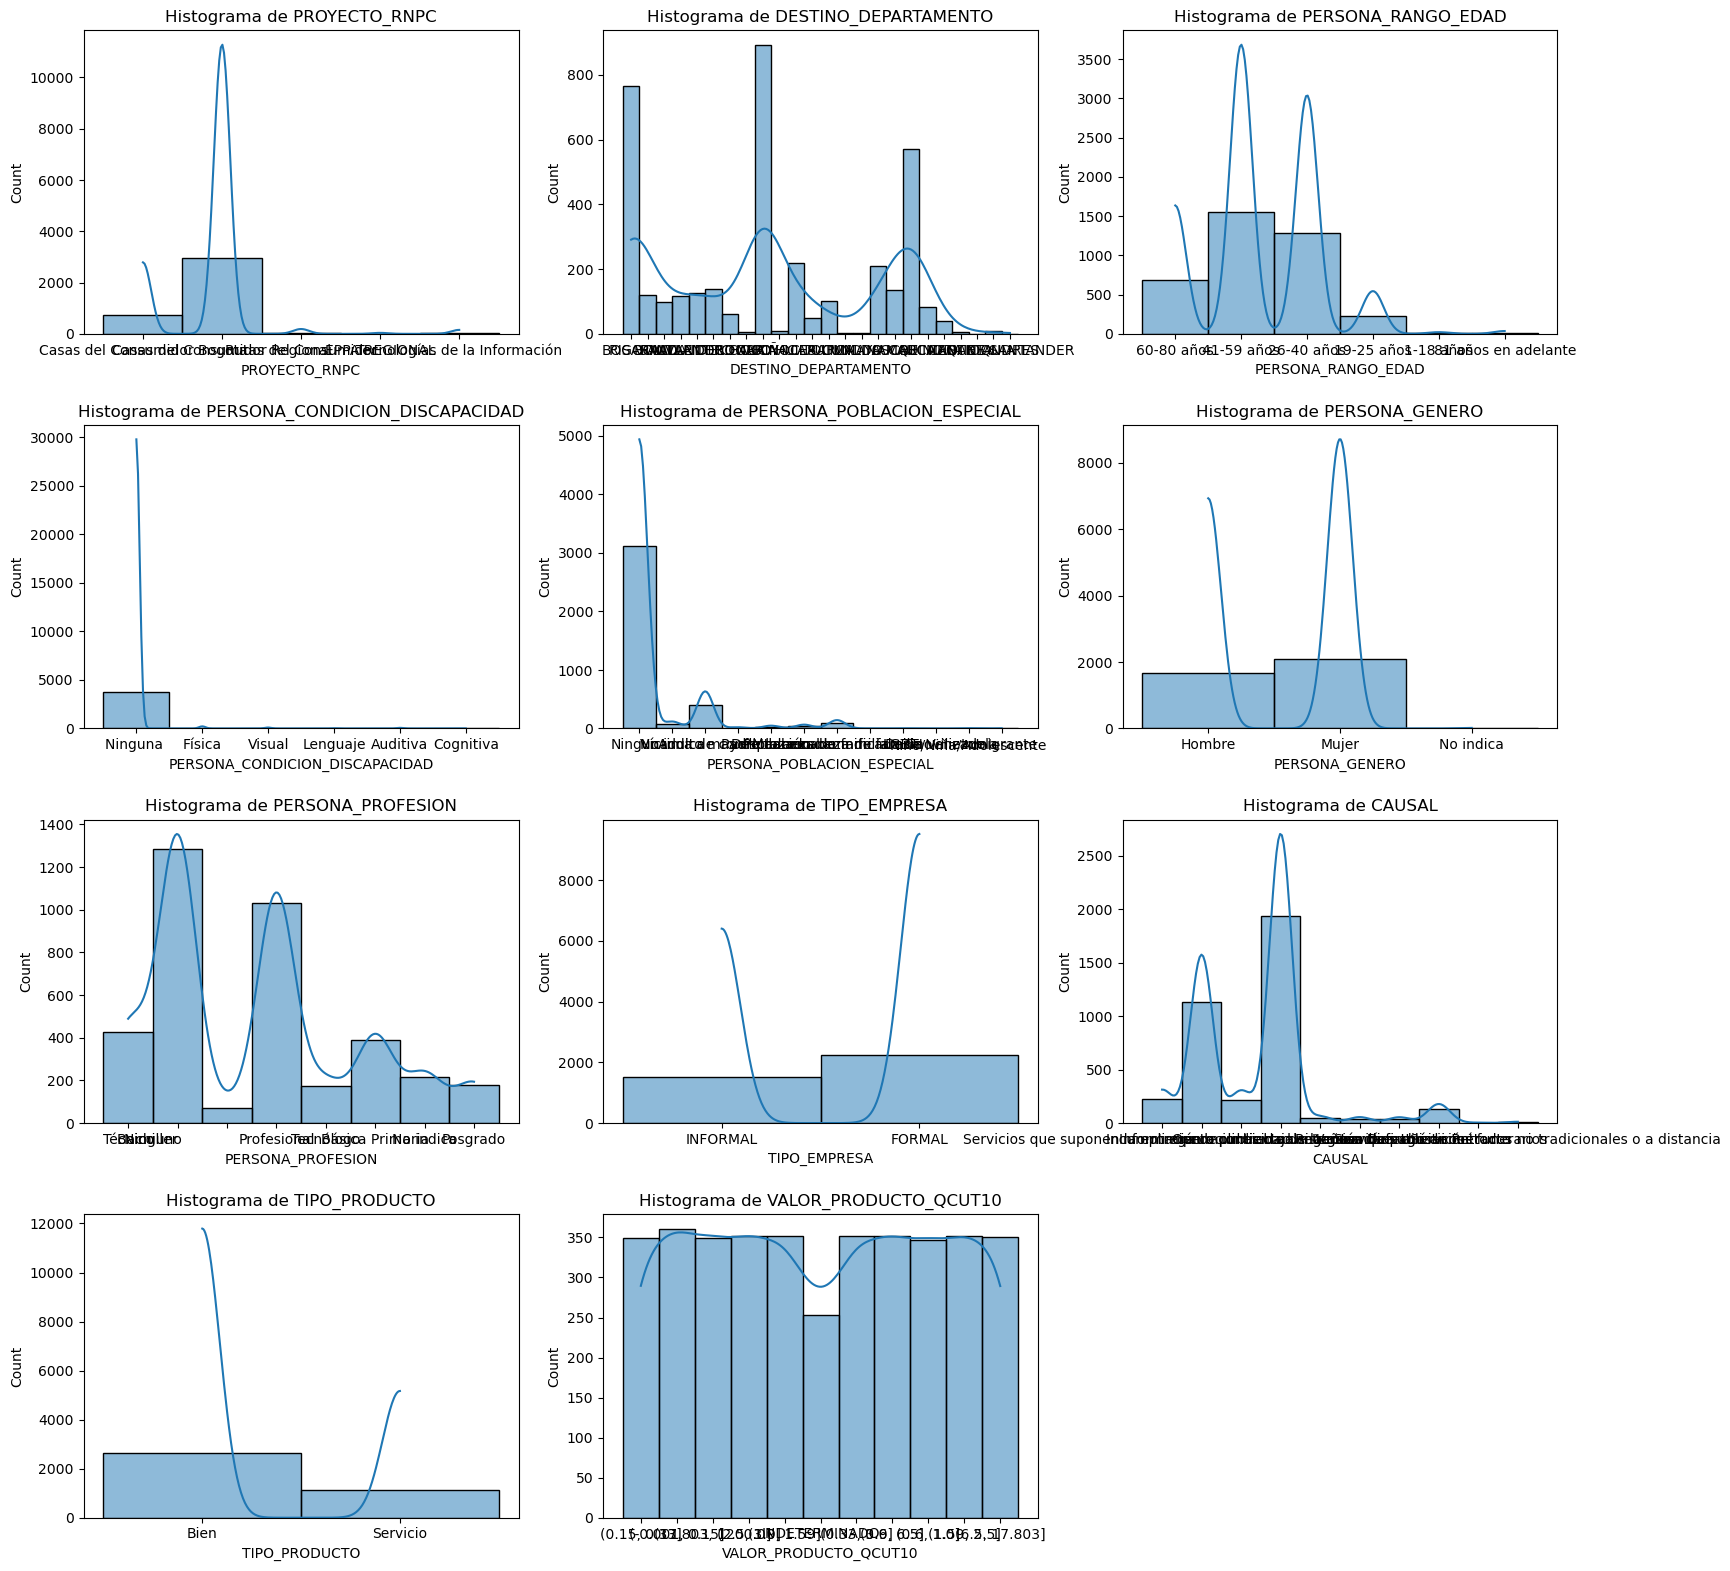

In [80]:
plot_histograms(XTotal)

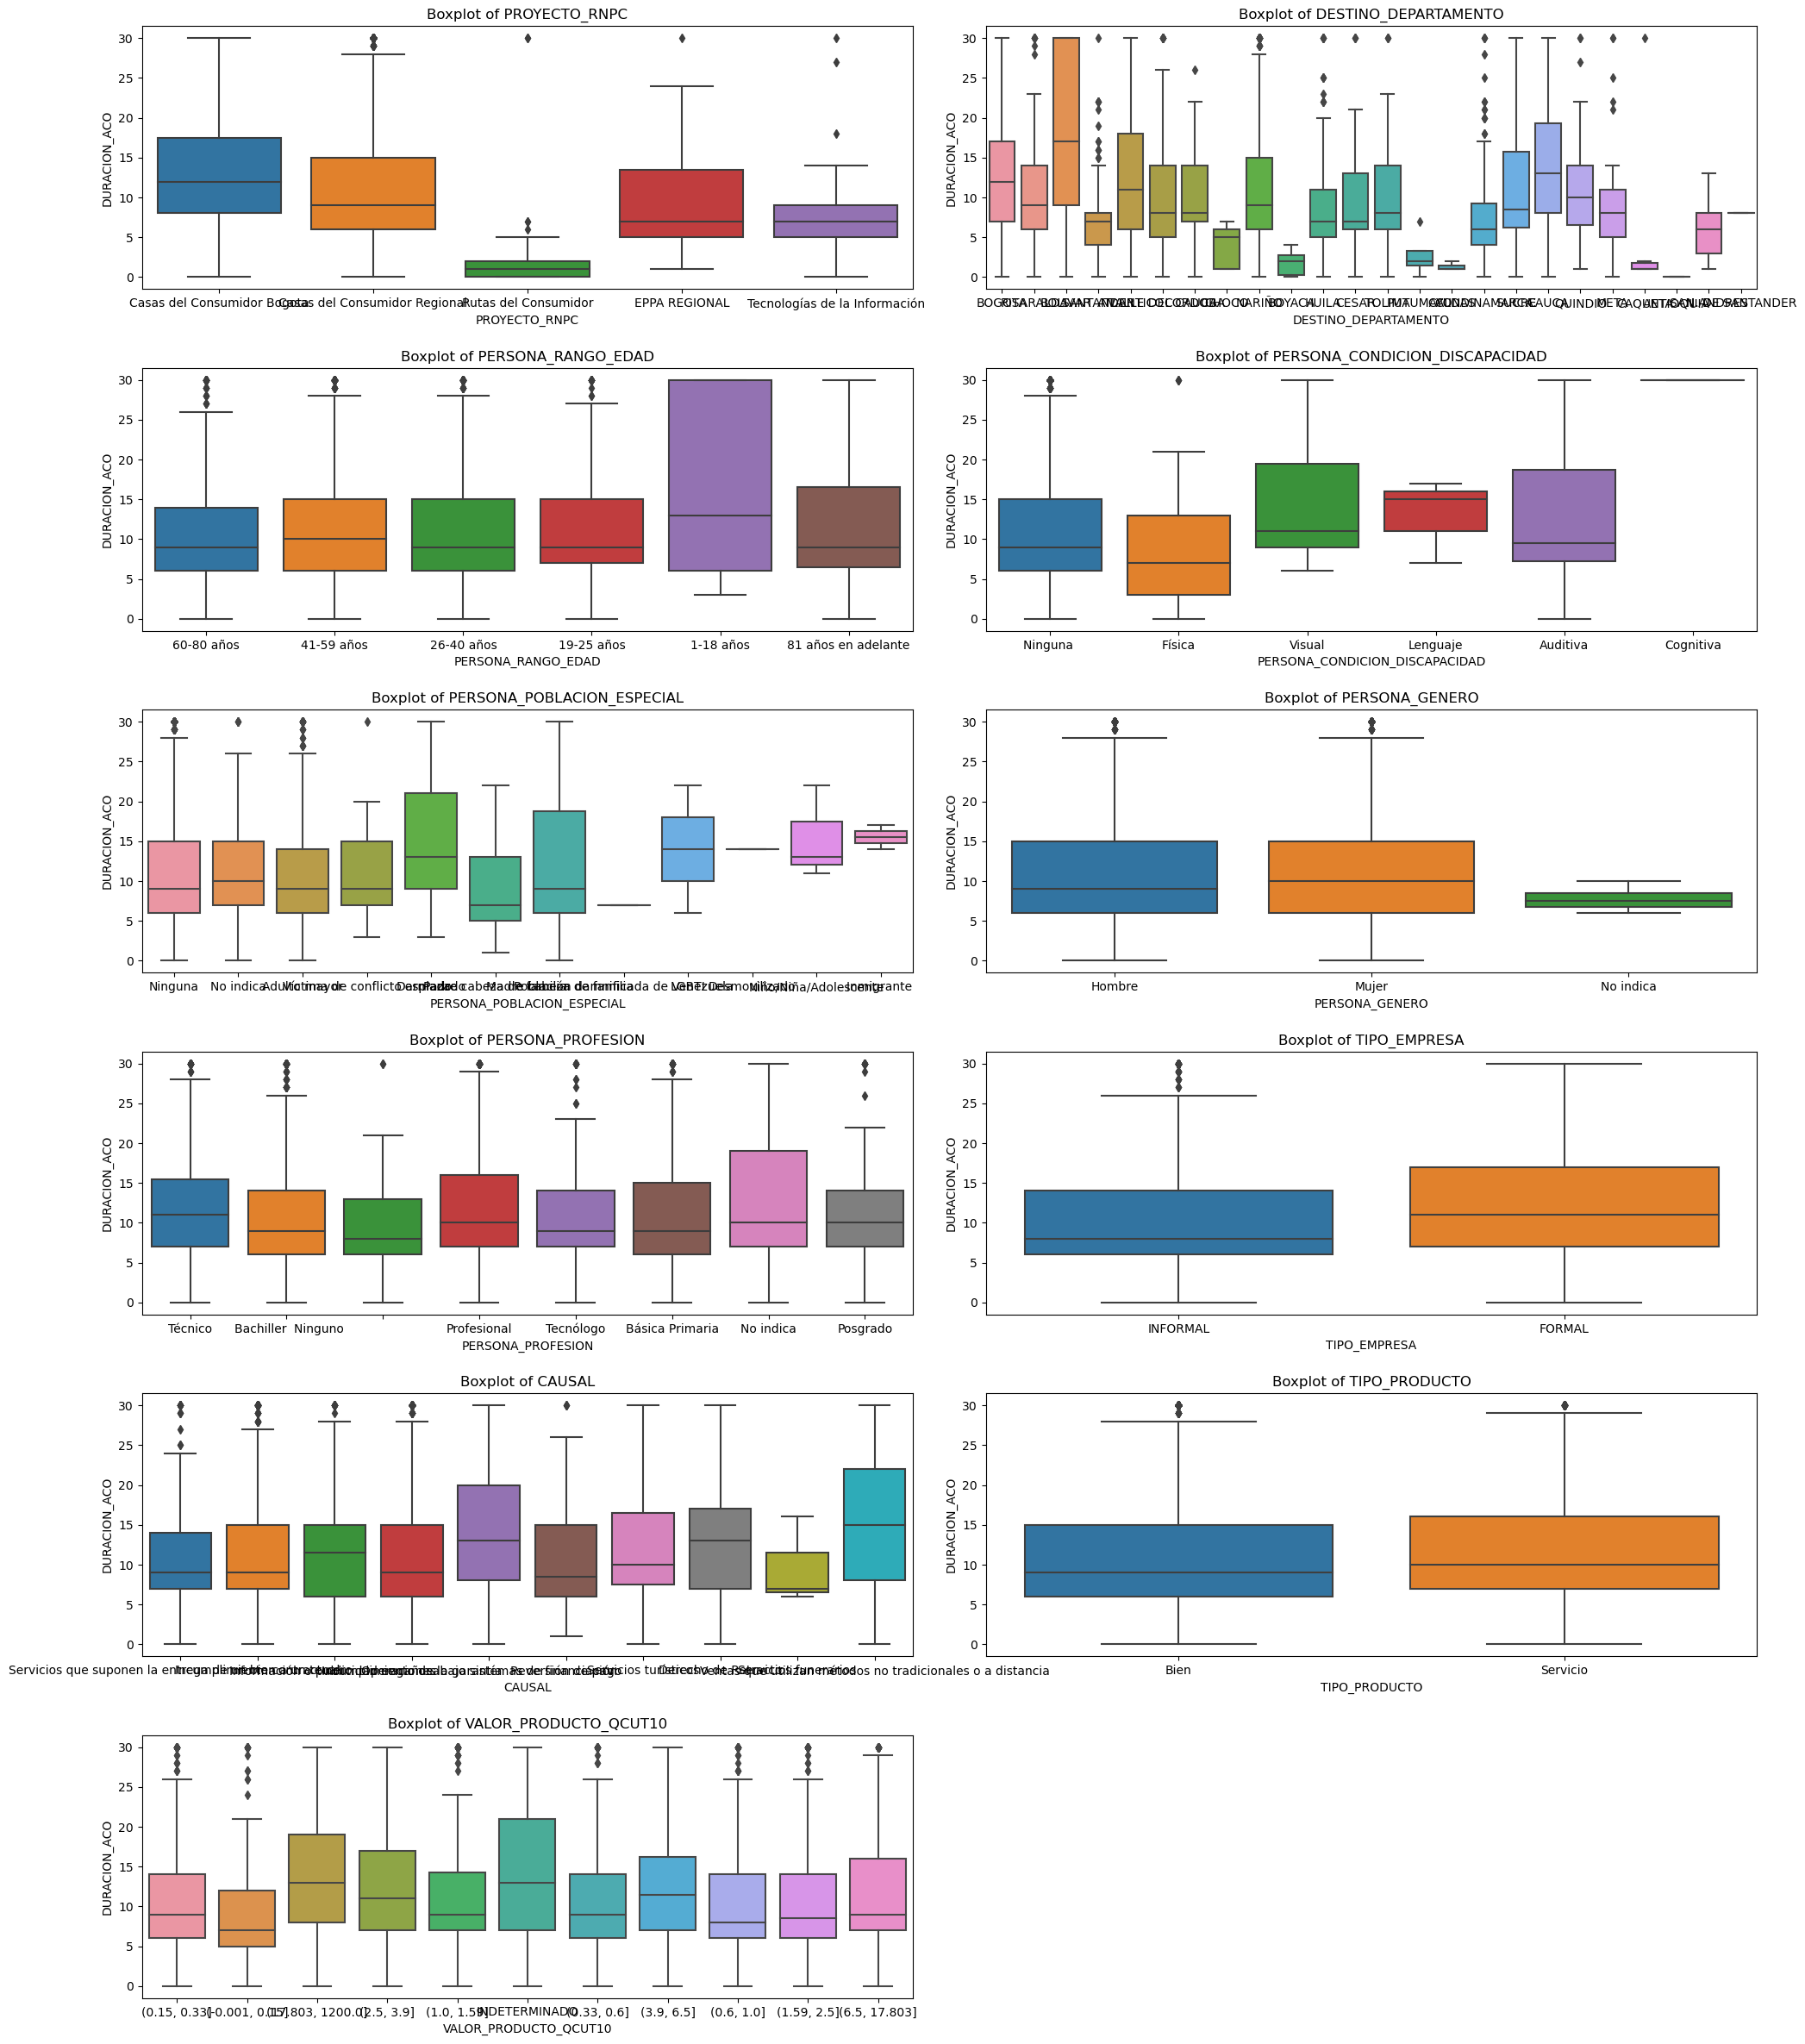

In [81]:
plot_boxplots_vscat(XTotal,yTotal['DURACION_ACO'])

### XTrain, XTest, yTrain, yTest

In [82]:
# Split the data into training and testing sets
XTrain, XTest, yTrain, yTest = train_test_split(XTotal, yTotal, test_size=0.33, random_state=0)

In [83]:
ohe = OneHotEncoder(sparse_output=False, drop='first', max_categories=15, handle_unknown='infrequent_if_exist')

In [84]:
XTrain_enc= ohe.fit_transform(XTrain)

In [85]:
XTrain_enc

array([[1., 0., 0., ..., 0., 1., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [1., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.]])

In [86]:
# Get the names of the encoded variables
encoded_variable_names = ohe.get_feature_names_out()

# Create a DataFrame with the encoded variables
XTrain_enc_df = pd.DataFrame(XTrain_enc, columns=encoded_variable_names)

# Display the DataFrame
XTrain_enc_df.head(2)

,PROYECTO_RNPC_Casas del Consumidor Regional,PROYECTO_RNPC_EPPA REGIONAL,PROYECTO_RNPC_Rutas del Consumidor,PROYECTO_RNPC_Tecnologías de la Información,DESTINO_DEPARTAMENTO_BOGOTA,DESTINO_DEPARTAMENTO_BOLIVAR,DESTINO_DEPARTAMENTO_CAUCA,DESTINO_DEPARTAMENTO_CORDOBA,DESTINO_DEPARTAMENTO_CUNDINAMARCA,DESTINO_DEPARTAMENTO_HUILA,...,"VALOR_PRODUCTO_QCUT10_(0.15, 0.33]","VALOR_PRODUCTO_QCUT10_(0.33, 0.6]","VALOR_PRODUCTO_QCUT10_(0.6, 1.0]","VALOR_PRODUCTO_QCUT10_(1.0, 1.59]","VALOR_PRODUCTO_QCUT10_(1.59, 2.5]","VALOR_PRODUCTO_QCUT10_(17.803, 1200.0]","VALOR_PRODUCTO_QCUT10_(2.5, 3.9]","VALOR_PRODUCTO_QCUT10_(3.9, 6.5]","VALOR_PRODUCTO_QCUT10_(6.5, 17.803]",VALOR_PRODUCTO_QCUT10_INDETERMINADO
0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [87]:
XTest_enc = ohe.transform(XTest)

/Users/alejandra/anaconda3/envs/MIAD/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


In [88]:
# Create a DataFrame with the encoded variables
XTest_enc_df = pd.DataFrame(XTest_enc, columns=encoded_variable_names)

# Display the DataFrame
XTest_enc_df.head(2)

,PROYECTO_RNPC_Casas del Consumidor Regional,PROYECTO_RNPC_EPPA REGIONAL,PROYECTO_RNPC_Rutas del Consumidor,PROYECTO_RNPC_Tecnologías de la Información,DESTINO_DEPARTAMENTO_BOGOTA,DESTINO_DEPARTAMENTO_BOLIVAR,DESTINO_DEPARTAMENTO_CAUCA,DESTINO_DEPARTAMENTO_CORDOBA,DESTINO_DEPARTAMENTO_CUNDINAMARCA,DESTINO_DEPARTAMENTO_HUILA,...,"VALOR_PRODUCTO_QCUT10_(0.15, 0.33]","VALOR_PRODUCTO_QCUT10_(0.33, 0.6]","VALOR_PRODUCTO_QCUT10_(0.6, 1.0]","VALOR_PRODUCTO_QCUT10_(1.0, 1.59]","VALOR_PRODUCTO_QCUT10_(1.59, 2.5]","VALOR_PRODUCTO_QCUT10_(17.803, 1200.0]","VALOR_PRODUCTO_QCUT10_(2.5, 3.9]","VALOR_PRODUCTO_QCUT10_(3.9, 6.5]","VALOR_PRODUCTO_QCUT10_(6.5, 17.803]",VALOR_PRODUCTO_QCUT10_INDETERMINADO
0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [89]:
from sklearn.utils import column_or_1d
#yTrain = yTrain.ravel()
yTrain_1Darray = column_or_1d(yTrain)
yTest_1Darray = column_or_1d(yTest)

### HistGradientBoostingRegressor

In [90]:
from sklearn.ensemble import HistGradientBoostingRegressor
hgbr= HistGradientBoostingRegressor(random_state=42)

In [91]:
import sklearn
print(sklearn.__version__)

1.3.0


In [92]:
hgbr.fit(XTrain_enc_df, yTrain_1Darray)

HistGradientBoostingRegressor(random_state=42)

In [93]:
hgbr_pred=hgbr.predict(XTest_enc_df)
hgbr_pred

array([14.5251763 ,  8.84016649, 11.26393619, ...,  8.8546746 ,
       10.57722025,  4.8395755 ])

In [94]:
hgbr_MSE=np.average(np.square(hgbr_pred-yTest_1Darray))
hgbr_RMSE = np.sqrt(hgbr_MSE)
print("MSE:", hgbr_MSE)
print("RMSE:", hgbr_RMSE)

MSE: 56.09810672473933
RMSE: 7.489866936384073


### RandomForestRegressor

#### GridSearch

In [95]:
kfold = KFold(n_splits=5, shuffle=True, random_state=0)

In [96]:
## Define Grid 
grid_rfr = { 
    'n_estimators': [5,10,50,100],
    'max_features': ['sqrt','log2'],
    'max_depth' : [3, 5, 10, 20],
    'min_samples_split' : [2,3,4,5], # NEW TO ME
    'random_state' : [0]
}

In [97]:
## show start time
print(datetime.now())
## Grid Search function
CV_rfr = GridSearchCV(estimator=RandomForestRegressor(), param_grid=grid_rfr, cv= kfold, scoring='neg_root_mean_squared_error', n_jobs=1)
CV_rfr.fit(XTrain_enc_df, yTrain_1Darray)
## show end time
print(datetime.now())

2024-03-16 17:12:09.347798
2024-03-16 17:12:36.333499


In [98]:
print("Mejores parámetros: {}".format(CV_rfr.best_params_)) 

Mejores parámetros: {'max_depth': 10, 'max_features': 'sqrt', 'min_samples_split': 2, 'n_estimators': 50, 'random_state': 0}


In [99]:
best_rfr = CV_rfr.best_estimator_

In [100]:
pred_rfr = best_rfr.predict(XTest_enc_df)

In [101]:
MSE_rfr=np.average(np.square(pred_rfr-yTest_1Darray))
RMSE_rfr = np.sqrt(MSE_rfr)
print("MSE RandomForestRegressor:", MSE_rfr)
print("RMSE RandomForestRegressor:", RMSE_rfr)

MSE RandomForestRegressor: 55.1583114140308
RMSE RandomForestRegressor: 7.426864170969521


In [102]:
feature_names = XTrain_enc_df.columns.tolist()
feature_names

['PROYECTO_RNPC_Casas del Consumidor Regional',
 'PROYECTO_RNPC_EPPA REGIONAL',
 'PROYECTO_RNPC_Rutas del Consumidor',
 'PROYECTO_RNPC_Tecnologías de la Información',
 'DESTINO_DEPARTAMENTO_BOGOTA',
 'DESTINO_DEPARTAMENTO_BOLIVAR',
 'DESTINO_DEPARTAMENTO_CAUCA',
 'DESTINO_DEPARTAMENTO_CORDOBA',
 'DESTINO_DEPARTAMENTO_CUNDINAMARCA',
 'DESTINO_DEPARTAMENTO_HUILA',
 'DESTINO_DEPARTAMENTO_NARIÑO',
 'DESTINO_DEPARTAMENTO_QUINDIO',
 'DESTINO_DEPARTAMENTO_RISARALDA',
 'DESTINO_DEPARTAMENTO_SANTANDER',
 'DESTINO_DEPARTAMENTO_SUCRE',
 'DESTINO_DEPARTAMENTO_TOLIMA',
 'DESTINO_DEPARTAMENTO_VALLE DEL CAUCA',
 'DESTINO_DEPARTAMENTO_infrequent_sklearn',
 'PERSONA_RANGO_EDAD_19-25 años',
 'PERSONA_RANGO_EDAD_26-40 años',
 'PERSONA_RANGO_EDAD_41-59 años',
 'PERSONA_RANGO_EDAD_60-80 años',
 'PERSONA_RANGO_EDAD_81 años en adelante',
 'PERSONA_CONDICION_DISCAPACIDAD_Cognitiva',
 'PERSONA_CONDICION_DISCAPACIDAD_Física',
 'PERSONA_CONDICION_DISCAPACIDAD_Lenguaje',
 'PERSONA_CONDICION_DISCAPACIDAD_Ninguna '

In [103]:
#Feature Importances
imp_RFR = pd.DataFrame({'Feature':feature_names,'Importance':np.round(best_rfr.feature_importances_,3)})
imp_RFR = imp_RFR.sort_values('Importance',ascending=False)
print(imp_RFR)

                                              Feature  Importance
47                              TIPO_EMPRESA_INFORMAL       0.070
6                          DESTINO_DEPARTAMENTO_CAUCA       0.069
5                        DESTINO_DEPARTAMENTO_BOLIVAR       0.052
2                  PROYECTO_RNPC_Rutas del Consumidor       0.044
8                   DESTINO_DEPARTAMENTO_CUNDINAMARCA       0.035
..                                                ...         ...
30             PERSONA_POBLACION_ESPECIAL_Inmigrante        0.000
25            PERSONA_CONDICION_DISCAPACIDAD_Lenguaje       0.000
36  PERSONA_POBLACION_ESPECIAL_Población damnifica...       0.000
53                        CAUSAL_Servicios funerarios       0.000
39                           PERSONA_GENERO_No indica       0.000

[68 rows x 2 columns]


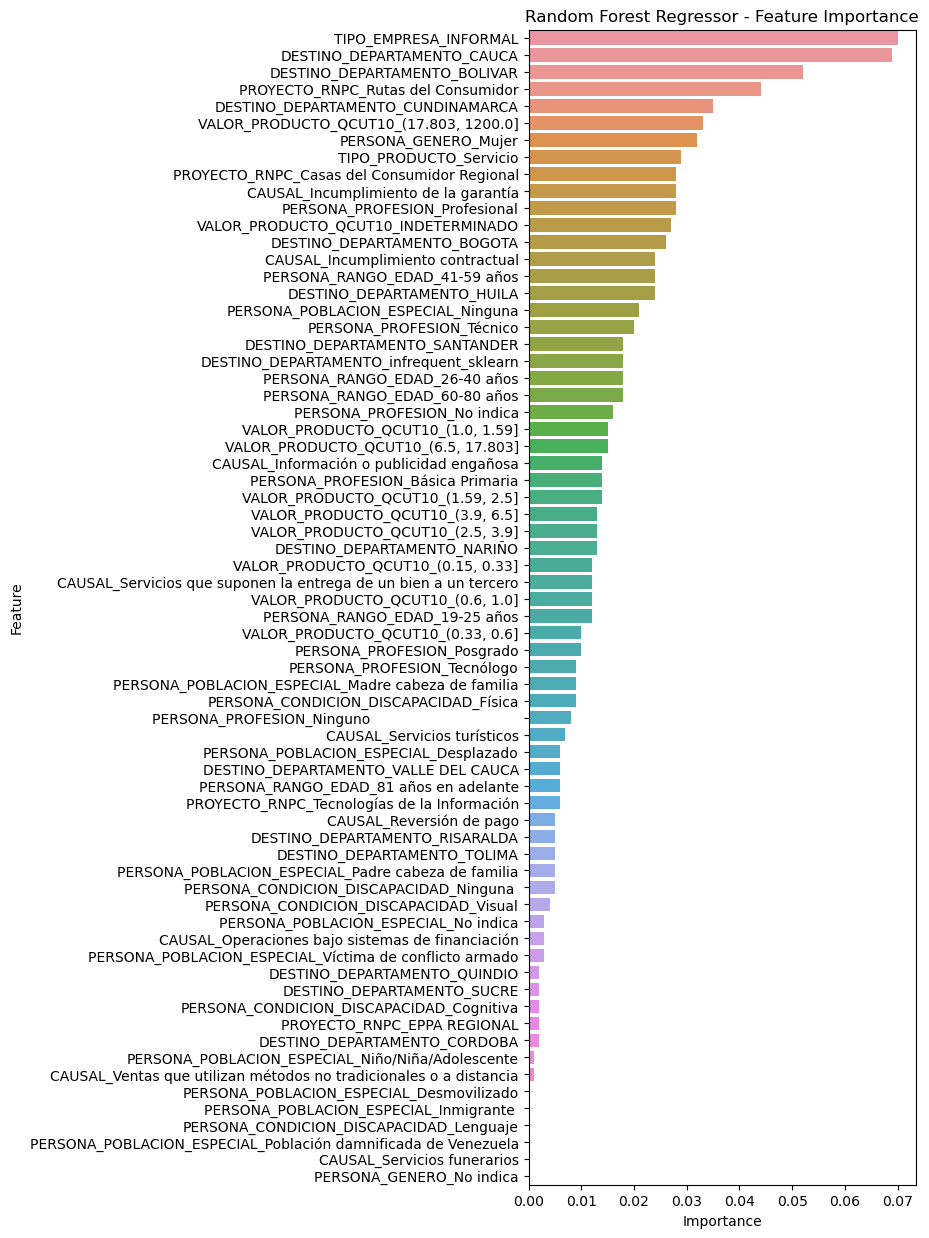

In [104]:
# Plotting the Feature Importance
plt.figure(figsize=(5, 15))
sns.barplot(x='Importance', y='Feature', data=imp_RFR)
plt.title('Random Forest Regressor - Feature Importance')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

### GBR 

In [105]:
gbr = GradientBoostingRegressor(n_estimators = 500, max_depth = 4, min_samples_split = 5,
                                learning_rate = 0.01, loss = 'squared_error')

In [106]:
gbr.fit(XTrain_enc_df, yTrain_1Darray)

GradientBoostingRegressor(learning_rate=0.01, max_depth=4, min_samples_split=5,
                          n_estimators=500)

In [107]:
gbr_pred=gbr.predict(XTest_enc_df)
gbr_pred

array([13.78281457,  7.85006438,  9.31217637, ..., 11.24674203,
       13.28122039,  7.49041918])

In [108]:
gbr_MSE=np.average(np.square(gbr_pred-yTest_1Darray))
gbr_RMSE = np.sqrt(gbr_MSE)
print("MSE GBR:", gbr_MSE)
print("RMSE GBR:", gbr_RMSE)

MSE GBR: 55.50997184264354
RMSE GBR: 7.450501449073313


In [109]:
#Feature Importances
imp_GBR = pd.DataFrame({'Feature':feature_names,'Importance':np.round(gbr.feature_importances_,3)})
imp_GBR = imp_GBR.sort_values('Importance',ascending=False)
print(imp_GBR)

                                              Feature  Importance
6                          DESTINO_DEPARTAMENTO_CAUCA       0.109
4                         DESTINO_DEPARTAMENTO_BOGOTA       0.093
5                        DESTINO_DEPARTAMENTO_BOLIVAR       0.088
47                              TIPO_EMPRESA_INFORMAL       0.078
2                  PROYECTO_RNPC_Rutas del Consumidor       0.054
..                                                ...         ...
36  PERSONA_POBLACION_ESPECIAL_Población damnifica...       0.000
33   PERSONA_POBLACION_ESPECIAL_Niño/Niña/Adolescente       0.000
30             PERSONA_POBLACION_ESPECIAL_Inmigrante        0.000
28           PERSONA_POBLACION_ESPECIAL_Desmovilizado       0.000
34               PERSONA_POBLACION_ESPECIAL_No indica       0.000

[68 rows x 2 columns]


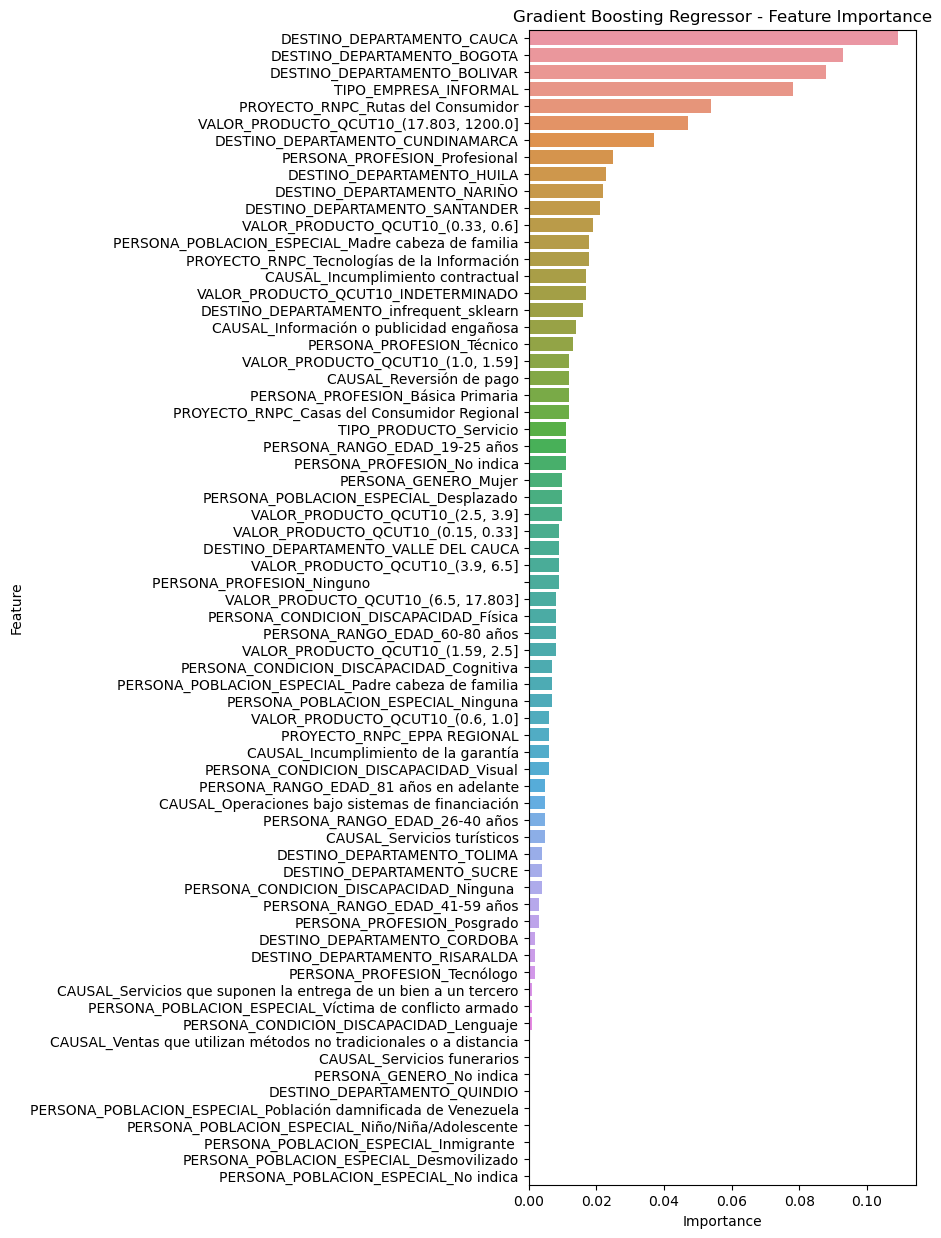

In [110]:
# Plotting the Feature Importance
plt.figure(figsize=(5, 15))
sns.barplot(x='Importance', y='Feature', data=imp_GBR)
plt.title('Gradient Boosting Regressor - Feature Importance')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

### PCA

In [111]:
p=len(XTrain_enc[1,]) # Calculates # of features
print(f"Numero de Variables: {p}")

Numero de Variables: 68


In [112]:
pca = PCA(n_components=p).fit(XTrain_enc_df)
# n_components=p specifies that the algorithm should compute as many principal components as there are 
# features in the dataset.
# fit(XEscaladoTrain) fits the PCA model to the scaled training data.
A=pca.components_
# retrieves principal components. Each row of A represents a principal component, and the columns correspond 
# to the original features. The principal components are the directions in the feature space along which the 
# data varies the most.

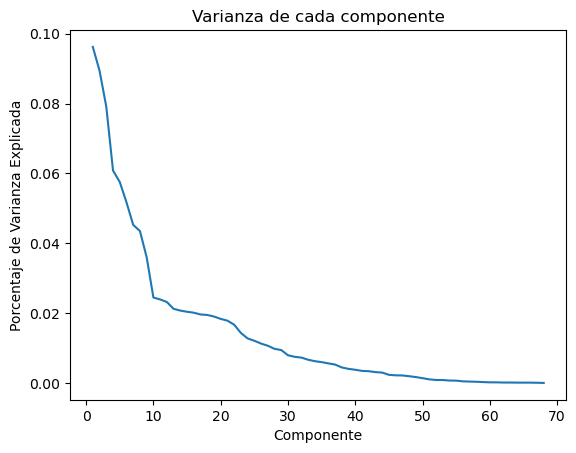

In [113]:
varianzaExplicada=pca.explained_variance_ 
# measure of how much information (variance) is contained in each principal component.
porcentajeVarianzaExplicada=pca.explained_variance_ratio_
# The proportion (%) of the dataset's variance explained by each of the selected components. 
plt.plot(range(1,p+1),porcentajeVarianzaExplicada)
plt.xlabel('Componente')
plt.ylabel('Porcentaje de Varianza Explicada')
plt.title('Varianza de cada componente')
plt.show()

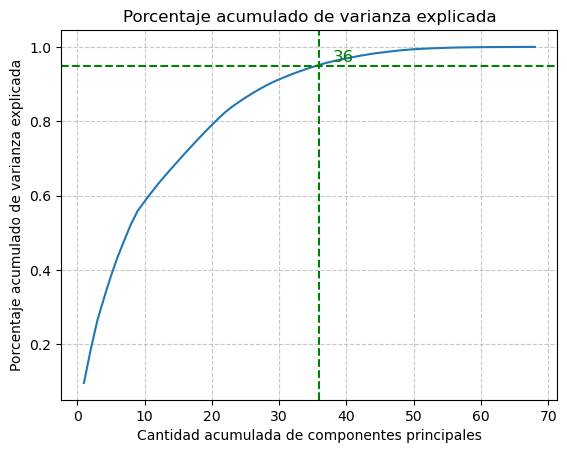

In [114]:
# Calculate the cumulative explained variance
cumulative_variance = np.cumsum(porcentajeVarianzaExplicada)

# Find the index where the cumulative explained variance first exceeds or equals 0.95
index_095 = np.argmax(cumulative_variance >= 0.95) + 1

# Plot the cumulative explained variance
plt.plot(range(1, p + 1), cumulative_variance)

# Add a horizontal line at y = 0.95
plt.axhline(y=0.95, color='g', linestyle='--')

# Add a vertical line at the index where cumulative explained variance crosses 0.95
plt.axvline(x=index_095, color='g', linestyle='--')

plt.grid(axis='both', linestyle='--', alpha=0.7)
plt.xlabel('Cantidad acumulada de componentes principales')
plt.ylabel('Porcentaje acumulado de varianza explicada')
plt.title('Porcentaje acumulado de varianza explicada')

# Annotate the number of components
plt.text(index_095 + 2, 0.96, f'{index_095}', color='g', fontsize=12)
plt.show()

In [115]:
nComponentesElegidas=36 # Varianza explicada 95%
ZTotalTrain=np.matmul(XTrain_enc,A)
# multiplies the scaled training data XEscaladoTrain by the matrix of principal components A. 
# The result is stored in ZTotalTrain, where each row represents a data point and each column 
# represents a chosen principal component
ZTrain = ZTotalTrain[:,range(nComponentesElegidas)]
# selects only the columns corresponding to the first nComponentesElegidas principal components. 
# The resulting matrix, ZTrain, contains the data transformed to the reduced feature space

In [116]:
ZTotalTest=np.matmul(XTest_enc,A)
ZTest = ZTotalTest[:,range(nComponentesElegidas)]
# applying the dimensionality reduction to the testing data using the same 
# principal components obtained from the training data. 

### PCA - Linear Regresssion

In [117]:
regPCA = LinearRegression()
regPCA.fit(ZTrain, yTrain_1Darray) 

LinearRegression()

In [118]:
pred_regPCA=regPCA.predict(ZTest)
MSE_regPCA=np.average(np.square(pred_regPCA-yTest_1Darray))
RMSE_regPCA = MSE_regPCA**0.5
print(f'MSE Regresion PCA: {MSE_regPCA}')
print(f'RMSE Regresion PCA: {RMSE_regPCA}')

MSE Regresion PCA: 57.6625543974469
RMSE Regresion PCA: 7.593586398892614


### PCA - RFR Regresssion

In [119]:
rfrPCA = RandomForestRegressor(random_state=0, n_jobs=-1)
rfrPCA.fit(ZTrain, yTrain_1Darray)

RandomForestRegressor(n_jobs=-1, random_state=0)

In [120]:
pred_rfrPCA = rfrPCA.predict(ZTest)
MSE_rfrPCA =np.average(np.square(pred_rfrPCA-yTest_1Darray))
RMSE_rfrPCA = MSE_rfrPCA**0.5
print(f'MSE Random Forest Regresion PCA: {MSE_rfrPCA}')
print(f'RMSE Random Forest Regresion PCA: {RMSE_rfrPCA}')

MSE Random Forest Regresion PCA: 60.78195684001298
RMSE Random Forest Regresion PCA: 7.796278396774514


### Feature Selection SKB - f_regression

In [121]:
from sklearn.feature_selection import SelectKBest, f_regression, mutual_info_regression

# k is the number of top features you want to select
k = 50  # Adjust the value of k as per your requirement
SKB_selector = SelectKBest(score_func=f_regression, k=k)

# Fit the selector on the training data
SKB_selector.fit(XTrain_enc_df, yTrain_1Darray)

SelectKBest(k=50, score_func=<function f_regression at 0x1398a1120>)

In [122]:
# Transform both the training and testing datasets to select the top k features
SKB_XTrain_selected = SKB_selector.transform(XTrain_enc_df)
SKB_XTest_selected = SKB_selector.transform(XTest_enc_df)

### HistGBR | SKB

In [123]:
hgbr_SKB= HistGradientBoostingRegressor(random_state=42)

In [124]:
hgbr_SKB.fit(SKB_XTrain_selected, yTrain_1Darray)

HistGradientBoostingRegressor(random_state=42)

In [125]:
hgbrSKB_pred=hgbr_SKB.predict(SKB_XTest_selected)
hgbrSKB_pred

array([14.66214366,  9.12739886, 10.27786632, ..., 10.0539621 ,
       11.19110871,  4.91214781])

In [126]:
hgbrSKB_MSE=np.average(np.square(hgbrSKB_pred-yTest_1Darray))
hgbrSKB_RMSE = np.sqrt(hgbrSKB_MSE)
print("MSE hgbrSKB:", hgbrSKB_MSE)
print("RMSE hgbrSKB:", hgbrSKB_RMSE)

MSE hgbrSKB: 56.88935925725964
RMSE hgbrSKB: 7.542503513904362


### RandomForestRegressor | SKB

#### GridSearch

In [127]:
kfold = KFold(n_splits=5, shuffle=True, random_state=0)

In [128]:
## Define Grid 
grid_rfrSKB = { 
    'n_estimators': [5,10,50,100],
    'max_features': ['sqrt','log2'],
    'max_depth' : [3, 5, 10, 20],
    'random_state' : [0]
}

In [129]:
## show start time
print(datetime.now())
## Grid Search function
CV_rfrSKB = GridSearchCV(estimator=RandomForestRegressor(), param_grid=grid_rfr, cv= kfold, scoring='neg_root_mean_squared_error', n_jobs=1)
CV_rfrSKB.fit(SKB_XTrain_selected, yTrain_1Darray)
## show end time
print(datetime.now())

2024-03-16 17:12:40.646243
2024-03-16 17:12:58.914256


In [130]:
print("Mejores parámetros: {}".format(CV_rfrSKB.best_params_)) 

Mejores parámetros: {'max_depth': 10, 'max_features': 'sqrt', 'min_samples_split': 5, 'n_estimators': 50, 'random_state': 0}


In [131]:
best_rfrSKB = CV_rfrSKB.best_estimator_

In [132]:
pred_rfrSKB = best_rfrSKB.predict(SKB_XTest_selected)

In [133]:
MSE_rfrSKB=np.average(np.square(pred_rfrSKB-yTest_1Darray))
RMSE_rfrSKB = np.sqrt(MSE_rfrSKB)
print("MSE RandomForestRegressor SKB:", MSE_rfrSKB)
print("RMSE RandomForestRegressor SKB:", RMSE_rfrSKB)

MSE RandomForestRegressor SKB: 55.20738342267322
RMSE RandomForestRegressor SKB: 7.430167119430977


### GBR | SKB

In [134]:
gbrSKB = GradientBoostingRegressor(n_estimators = 500, max_depth = 4, min_samples_split = 5,
                                learning_rate = 0.01, loss = 'squared_error')

In [135]:
gbrSKB.fit(SKB_XTrain_selected, yTrain_1Darray)

GradientBoostingRegressor(learning_rate=0.01, max_depth=4, min_samples_split=5,
                          n_estimators=500)

In [136]:
gbrSKB_pred=gbrSKB.predict(SKB_XTest_selected)
gbrSKB_pred

array([13.62271832,  7.46734297,  9.27455053, ..., 11.23188004,
       13.14029047,  7.3221071 ])

In [137]:
gbrSKB_MSE=np.average(np.square(gbrSKB_pred-yTest_1Darray))
gbrSKB_RMSE = np.sqrt(gbrSKB_MSE)
print("MSE GBR SKB:", gbrSKB_MSE)
print("RMSE GBR SKB:", gbrSKB_RMSE)

MSE GBR SKB: 55.58009412709004
RMSE GBR SKB: 7.4552058406921295


### RFE  Feature Selection - RandomForestRegressor

In [138]:
estimator_rfr = RandomForestRegressor(n_estimators=100, max_depth = 5, random_state=0, n_jobs=-1) 

In [139]:
selector_rfr = RFECV(estimator=estimator_rfr, step=1, cv=5, scoring='neg_root_mean_squared_error')

In [140]:
## show start time
print(datetime.now())
selector_rfr = selector_rfr.fit(XTrain_enc_df, yTrain_1Darray) 
## show end time
print(datetime.now())

2024-03-16 17:12:59.740020
2024-03-16 17:13:32.505938


In [141]:
selector_rfr.support_  #Conjunto de variables seleccionadas

array([ True, False,  True,  True,  True,  True,  True, False,  True,
       False,  True, False, False, False, False, False, False, False,
       False, False,  True,  True, False, False, False, False, False,
       False, False,  True, False,  True,  True, False, False, False,
       False, False,  True, False, False, False,  True, False,  True,
        True,  True,  True,  True,  True, False, False,  True, False,
       False,  True, False,  True,  True, False, False, False,  True,
        True,  True,  True,  True,  True])

In [142]:
selected_indices_rfr = np.where(selector_rfr.support_)[0]
selected_indices_rfr

array([ 0,  2,  3,  4,  5,  6,  8, 10, 20, 21, 29, 31, 32, 38, 42, 44, 45,
       46, 47, 48, 49, 52, 55, 57, 58, 62, 63, 64, 65, 66, 67])

In [143]:
XTrain_enc_selected_rfr = XTrain_enc_df.iloc[:, selected_indices_rfr] 
XTrain_enc_selected_rfr.head(4)

,PROYECTO_RNPC_Casas del Consumidor Regional,PROYECTO_RNPC_Rutas del Consumidor,PROYECTO_RNPC_Tecnologías de la Información,DESTINO_DEPARTAMENTO_BOGOTA,DESTINO_DEPARTAMENTO_BOLIVAR,DESTINO_DEPARTAMENTO_CAUCA,DESTINO_DEPARTAMENTO_CUNDINAMARCA,DESTINO_DEPARTAMENTO_NARIÑO,PERSONA_RANGO_EDAD_41-59 años,PERSONA_RANGO_EDAD_60-80 años,...,CAUSAL_Reversión de pago,CAUSAL_Servicios turísticos,TIPO_PRODUCTO_Servicio,"VALOR_PRODUCTO_QCUT10_(0.15, 0.33]","VALOR_PRODUCTO_QCUT10_(1.59, 2.5]","VALOR_PRODUCTO_QCUT10_(17.803, 1200.0]","VALOR_PRODUCTO_QCUT10_(2.5, 3.9]","VALOR_PRODUCTO_QCUT10_(3.9, 6.5]","VALOR_PRODUCTO_QCUT10_(6.5, 17.803]",VALOR_PRODUCTO_QCUT10_INDETERMINADO
0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [144]:
estimator_rfr.fit(XTrain_enc_selected_rfr, yTrain_1Darray)

RandomForestRegressor(max_depth=5, n_jobs=-1, random_state=0)

In [145]:
XTest_enc_selected_rfr = XTest_enc_df.iloc[:, selected_indices_rfr]
XTest_enc_selected_rfr.head(4)

,PROYECTO_RNPC_Casas del Consumidor Regional,PROYECTO_RNPC_Rutas del Consumidor,PROYECTO_RNPC_Tecnologías de la Información,DESTINO_DEPARTAMENTO_BOGOTA,DESTINO_DEPARTAMENTO_BOLIVAR,DESTINO_DEPARTAMENTO_CAUCA,DESTINO_DEPARTAMENTO_CUNDINAMARCA,DESTINO_DEPARTAMENTO_NARIÑO,PERSONA_RANGO_EDAD_41-59 años,PERSONA_RANGO_EDAD_60-80 años,...,CAUSAL_Reversión de pago,CAUSAL_Servicios turísticos,TIPO_PRODUCTO_Servicio,"VALOR_PRODUCTO_QCUT10_(0.15, 0.33]","VALOR_PRODUCTO_QCUT10_(1.59, 2.5]","VALOR_PRODUCTO_QCUT10_(17.803, 1200.0]","VALOR_PRODUCTO_QCUT10_(2.5, 3.9]","VALOR_PRODUCTO_QCUT10_(3.9, 6.5]","VALOR_PRODUCTO_QCUT10_(6.5, 17.803]",VALOR_PRODUCTO_QCUT10_INDETERMINADO
0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [146]:
rfrRFE_pred = estimator_rfr.predict(XTest_enc_selected_rfr)

In [147]:
rfrRFE_MSE=np.average(np.square(rfrRFE_pred-yTest_1Darray))
rfrRFE_RMSE = np.sqrt(rfrRFE_MSE)
print("MSE RFR RFE:", rfrRFE_MSE)
print("RMSE RFR RFE:", rfrRFE_RMSE)

MSE RFR RFE: 56.27784556737525
RMSE RFR RFE: 7.501856141474272


### Seleccion de variables Secuencial - Forward 

In [148]:
p=len(XTrain_enc[1,])
# calculates the number of elements in row 1, which is equivalent to the number of columns = # variables
datosTrain=len(yTrain_1Darray)
# represents the number of elements (or samples) in the yTrain

In [149]:
r2adj = []

In [150]:
for a in range(1,p+1):
    if(a<(p)):
        # Feature Selection with SequentialFeatureSelector:
        sfs = SequentialFeatureSelector(LinearRegression(), n_features_to_select=a, direction='forward')
        sfs.fit(XTrain_enc_df,yTrain_1Darray)
        XTrainSeleccionado=sfs.fit_transform(XTrain_enc_df, yTrain_1Darray)
        # Creates a SequentialFeatureSelector object using a linear regression model.
        # It sets the number of features to select (n_features_to_select) to the current iteration variable a 
        # and uses the 'forward' direction, meaning it adds features one by one based on their contribution to 
        # the model
        
        # Linear Regression Model Fitting:
        regAuxiliar = LinearRegression()
        regAuxiliar.fit(XTrainSeleccionado, yTrain_1Darray)
        r2Modelo = regAuxiliar.score(XTrainSeleccionado, yTrain_1Darray)
        
        #Adjusted R-squared Calculation:
        r2adjModelo = 1-(1-r2Modelo)*(datosTrain-1)/(datosTrain-a-1)
        r2adj.append(r2adjModelo)
    else:
        regAuxiliar = LinearRegression()
        regAuxiliar.fit(XTrain_enc_df, yTrain_1Darray)
        r2Modelo = regAuxiliar.score(XTrain_enc_df, yTrain_1Darray)
        r2adjModelo=1-(1-r2Modelo)*(datosTrain-1)/(datosTrain-a-1)
        r2adj.append(r2adjModelo)
    
    mensaje = ['Evaluación del modelo con', str(a), ' variable(s) - R-squared Ajustado:', str(r2adjModelo)]
    print(" ".join(mensaje))

Evaluación del modelo con 1  variable(s) - R-squared Ajustado: 0.023517777786293048
Evaluación del modelo con 2  variable(s) - R-squared Ajustado: 0.04635321516828006
Evaluación del modelo con 3  variable(s) - R-squared Ajustado: 0.06879574337378003
Evaluación del modelo con 4  variable(s) - R-squared Ajustado: 0.08095764587977605
Evaluación del modelo con 5  variable(s) - R-squared Ajustado: 0.09162308634616789
Evaluación del modelo con 6  variable(s) - R-squared Ajustado: 0.09908856720807169
Evaluación del modelo con 7  variable(s) - R-squared Ajustado: 0.10276022668224394
Evaluación del modelo con 8  variable(s) - R-squared Ajustado: 0.10786875536548857
Evaluación del modelo con 9  variable(s) - R-squared Ajustado: 0.10930026805883197
Evaluación del modelo con 10  variable(s) - R-squared Ajustado: 0.11096246890930683
Evaluación del modelo con 11  variable(s) - R-squared Ajustado: 0.1122008670461434
Evaluación del modelo con 12  variable(s) - R-squared Ajustado: 0.11315737730996434
E

KeyboardInterrupt: 

In [ ]:
plt.plot(range(1,p+1),r2adj)
plt.xlabel('Número de variables')
plt.title('R^2 ajustado')
plt.show()

In [ ]:
nVariablesSeleccionadas=np.argmax(r2adj)+1
# No me queda claro porque mas 1 above
if(nVariablesSeleccionadas<p):
    sfsElegido = SequentialFeatureSelector(LinearRegression(), n_features_to_select=nVariablesSeleccionadas)
    sfsElegido.fit(XTrain_enc_df, yTrain_1Darray)
    XTrainSeleccionado=sfsElegido.fit_transform(XTrain_enc, yTrain_1Darray)
    modeloFwd = LinearRegression()
    modeloFwd.fit(XTrainSeleccionado, yTrain_1Darray)
    variablesSeleccionadas=np.array(range(1,p+1))[sfsElegido.get_support()]
else:
    modeloFwd = LinearRegression()
    modeloFwd.fit(XTrain_enc_df, yTrain_1Darray)
    variablesSeleccionadas=np.array(range(1,p+1))
    
mensaje = ['El número de variables seleccionadas es', str(nVariablesSeleccionadas),'y corresponden a las columnas:',str(variablesSeleccionadas)]
print(" ".join(mensaje))

In [ ]:
prediccionFwd=modeloFwd.predict(XTest_enc_df[:,variablesSeleccionadas-1])

In [ ]:
MSEFwd=np.average(np.square(prediccionFwd-yTest_1Darray))
RMSEFwd = np.sqrt(MSEFwd)
print("MSE RL Forward:", MSEFwd)
print("RMSE RFR RFE:", RMSEFwd)